In [ ]:
!pip install missingno
!pip install tune-sklearn
!pip install catboost

<h1><center><b>NCAA March Madness 2022 Notebook</b></center></h1>

### Load Libraries

In [ ]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.metrics import classification_report
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

pd.set_option('display.max_columns', None)

from google.colab import drive
# Mount drive from Google
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load Dataset

In [ ]:
# Define paths
root_path = '/content/gdrive/MyDrive/Kaggle_competitions/March Machine Learning Mania 2022 - Men’s'
output_path = root_path + '/output'
submissions_path = root_path + '/submissions'
models_path = root_path + '/models'

# Define random state for reproducibility
random_state = 0

In [ ]:
# Install kaggle
!pip -q install kaggle

# Upload the JSON file downloaded from kaggle (API token).
os.environ['KAGGLE_CONFIG_DIR'] = root_path + "/Kaggle"

kaggle_path = "'" + root_path +"/Kaggle'"
%cd $kaggle_path

# Download the dataset in zip format
!kaggle competitions download -c mens-march-mania-2022

# # List all the datasets available in Kaggle
# # !kaggle datasets list

# #Decompress the data
!unzip -o -q MGameCities.csv.zip
!unzip -o -q MMasseyOrdinals.csv.zip
!unzip -o -q MRegularSeasonCompactResults.csv.zip
!unzip -o -q MRegularSeasonDetailedResults.csv.zip

/content/gdrive/MyDrive/Kaggle_competitions/March Machine Learning Mania 2022 - Men’s/Kaggle
MNCAATourneySeeds.csv: Skipping, found more recently modified local copy (use --force to force download)
Conferences.csv: Skipping, found more recently modified local copy (use --force to force download)
MSecondaryTourneyTeams.csv: Skipping, found more recently modified local copy (use --force to force download)
MNCAATourneySeedRoundSlots.csv: Skipping, found more recently modified local copy (use --force to force download)
MRegularSeasonDetailedResults.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
MTeams.csv: Skipping, found more recently modified local copy (use --force to force download)
Cities.csv: Skipping, found more recently modified local copy (use --force to force download)
MSecondaryTourneyCompactResults.csv: Skipping, found more recently modified local copy (use --force to force download)
MRegularSeasonCompactResults.csv.zip: Skipping, fou

In [ ]:
DATA_PATH = root_path + "/Kaggle/"
# DATA_PATH = '../input/ncaaw-march-mania-2022/'
# DATA_PATH_M = '../input/ncaam-march-mania-2022/'

for filename in os.listdir(DATA_PATH):
    print(filename)

kaggle.json
MSecondaryTourneyCompactResults.csv
MRegularSeasonDetailedResults.csv.zip
MNCAATourneyCompactResults.csv
MNCAATourneySlots.csv
Conferences.csv
MSampleSubmissionStage1.csv
MNCAATourneyDetailedResults.csv
MTeamConferences.csv
MTeamSpellings.csv
MNCAATourneySeedRoundSlots.csv
Cities.csv
MSeasons.csv
MNCAATourneySeeds.csv
MGameCities.csv.zip
MRegularSeasonCompactResults.csv.zip
MTeams.csv
MTeamCoaches.csv
MMasseyOrdinals.csv.zip
MConferenceTourneyGames.csv
MSecondaryTourneyTeams.csv
MGameCities.csv
MMasseyOrdinals.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
catboost_info


## 2.) Exploratory Data Analysis

### 2A.) Seeds

The Tournament Selection Committee seeds every team in the NCAA Tournament ranging from 1 (the best teams) to 16 (the worst ones). The tournament started with 8 teams in 1939 and has since expanded to 68 teams today (4 play-in games). On Selection Sunday (March 13, 2022), the committee releases the bracket with the seeds.

* First character : Region (W, X, Y, or Z)
* Next two digits : Seed within the region (01 to 16)
* Last character (optional): Distinguishes teams between play-ins ( a or b)

In [ ]:
df_seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### 2B.) Season Results

In [ ]:
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
# df_season_results = pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [ ]:
df_season_results['ScoreMargin'] = df_season_results['WScore'] - df_season_results['LScore']

In [ ]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreMargin
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,6
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,7
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,12
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,6
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,6


In [ ]:
sabermetrics = pd.DataFrame()

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']

# Number of Possessions
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .44 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .44 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Offensive Rebound Percentage
sabermetrics['WOReboundPct'] = df_season_results['WOR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])
sabermetrics['LOReboundPct'] = df_season_results['LOR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])

# Defensive Rebound Percentage
sabermetrics['WDReboundPct'] = df_season_results['WDR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LDReboundPct'] = df_season_results['LDR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Assist to Turnover Ratio
sabermetrics['WATORatio'] = df_season_results['WAst'] / df_season_results['WTO']
sabermetrics['LATORatio'] = df_season_results['LAst'] / df_season_results['LTO']

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']


In [ ]:
winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]
winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
winning_columns.groupby(['Season', 'WTeamID']).mean()


WPossessions  WPtsPerPoss  WEffectiveFGPct  WAssistRate  WOReboundPct  WDReboundPct  WATORatio   WTORate  WBArcPct   WFTRate
Season WTeamID                                                                                                                              
2003   1102        56.380000     1.224741         0.692162     0.746082      0.216934      0.693586   1.875770  0.194352  0.536901  0.541714
       1103        72.144615     1.218303         0.592604     0.593458      0.365924      0.665062   1.534233  0.175252  0.263396  0.554488
       1104        67.795294     1.103197         0.506056     0.551302      0.413266      0.749571   1.177279  0.191923  0.357570  0.392488
       1105        76.600000     1.036343         0.488400     0.618892      0.404129      0.754657   0.942261  0.235009  0.366514  0.425332
       1106        67.907692     1.005881         0.517668     0.530133      0.431874      0.805576   0.756597  0.261162  0.301302  0.395797
...                      ...          ...              ...          ...           ...           ...        ...       ...       ...       ...
2022   1468        63.053333     1.183584         0.592994     0.601700      0.200470      0.718124   2.592229  0.126370  0.396946  0.240419
       1469        72.794286     1.096535         0.533165     0.636728      0.272403      0.728655   1.525541  0.162211  0.359522  0.353851
       1470        63.610000     1.111743         0.536540     0.551508      0.260685      0.691702   1.715395  0.144818  0.337367  0.352914
       1471        71.210000     1.115187         0.577662     0.540697      0.166350      0.721321   1.104673  0.186423  0.450288  0.487936
       1472        66.320000     1.272991         0.620242     0.519341      0.187473      0.717819   2.698333  0.103040  0.541325  0.222046

[6883 rows x 10 columns]

In [ ]:
losing_columns.groupby(['Season', 'LTeamID']).mean()

LPossessions  LPtsPerPoss  LEffectiveFGPct  LAssistRate  LOReboundPct  LDReboundPct  LATORatio   LTORate  LBArcPct   LFTRate
Season LTeamID                                                                                                                              
2003   1102        53.200000     0.917240         0.503591     0.604671      0.186039      0.756516   0.999534  0.216997  0.504743  0.375427
       1103        68.160000     1.028430         0.484527     0.529464      0.313076      0.703148   1.129718  0.187378  0.312603  0.382163
       1104        63.483636     0.955762         0.429002     0.431948      0.396990      0.738274   0.706652  0.215706  0.329571  0.341227
       1105        76.301053     0.903714         0.446777     0.583636      0.346275      0.718607   0.832372  0.246354  0.328804  0.335248
       1106        66.736000     0.891659         0.450522     0.467619      0.346249      0.717663   0.694235  0.246039  0.340581  0.231093
...                      ...          ...              ...          ...           ...           ...        ...       ...       ...       ...
2022   1468        65.178182     0.922326         0.467822     0.463976      0.191651      0.684441   1.132917  0.170184  0.400730  0.228603
       1469        75.080000     0.851263         0.431333     0.594451      0.238385      0.748675   0.924233  0.226333  0.378163  0.399463
       1470        66.575385     0.884939         0.416007     0.379926      0.207885      0.679568   0.798383  0.160190  0.287187  0.296166
       1471        67.583333     0.876517         0.470668     0.519170      0.158521      0.670214   0.989052  0.194125  0.447261  0.282874
       1472        68.285714     1.005266         0.491830     0.431302      0.160303      0.724849   1.429921  0.121470  0.486120  0.213144

[6889 rows x 10 columns]

In [ ]:
sabermetrics_season_w = winning_columns.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
sabermetrics_season_l = losing_columns.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

### Compute Wins, Losses, ScoreMarginWin, ScoreMarginLoss

In [ ]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"}).fillna(0)

In [ ]:
num_win.isna().sum()

Season     0
TeamID     0
NumWins    0
dtype: int64

In [ ]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"}).fillna(0)

In [ ]:
win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_score_margin = win_score_margin[['Season', 'WTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgWinningScoreMargin", "WTeamID": "TeamID"}).fillna(0)

In [ ]:
lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
lose_score_margin = lose_score_margin[['Season', 'LTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgLosingScoreMargin", "LTeamID": "TeamID"}).fillna(0)

## Merge the results together

In [ ]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [ ]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [ ]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(win_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(lose_score_margin, on=['Season', 'TeamID'], how='left')

In [ ]:
df_features_season

,Season,TeamID,NumWins,NumLosses,AvgWinningScoreMargin,AvgLosingScoreMargin
0,2003,1102,12.0,16.0,15.583333,11.250000
1,2003,1103,13.0,14.0,9.384615,7.500000
2,2003,1104,17.0,11.0,13.176471,9.454545
3,2003,1105,7.0,19.0,13.000000,11.473684
4,2003,1106,13.0,15.0,10.384615,9.266667
...,...,...,...,...,...,...
6887,2022,1468,9.0,11.0,10.666667,16.545455
6888,2022,1469,7.0,12.0,11.428571,19.333333
6889,2022,1470,8.0,13.0,11.125000,11.769231
6890,2022,1471,8.0,12.0,10.125000,13.416667


In [ ]:
df_features_season['NumWins'] = df_features_season['NumWins'].fillna(0)
df_features_season['NumLosses'] = df_features_season['NumLosses'].fillna(0)
df_features_season['AvgWinningScoreMargin'] = df_features_season['AvgWinningScoreMargin'].fillna(0)
df_features_season['AvgLosingScoreMargin'] = df_features_season['AvgLosingScoreMargin'].fillna(0)

In [ ]:
df_features_season['WinPercentage'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['AvgScoringMargin'] = (
    (df_features_season['NumWins'] * df_features_season['AvgWinningScoreMargin'] - 
    df_features_season['NumLosses'] * df_features_season['AvgLosingScoreMargin'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [ ]:
df_features_season.drop(['AvgWinningScoreMargin', 'AvgLosingScoreMargin'], axis=1, inplace=True)

In [ ]:
df_features_season.isna().sum()

Season              0
TeamID              0
NumWins             0
NumLosses           0
WinPercentage       0
AvgScoringMargin    0
dtype: int64

In [ ]:
df_features_season

,Season,TeamID,NumWins,NumLosses,WinPercentage,AvgScoringMargin
0,2003,1102,12.0,16.0,0.428571,0.250000
1,2003,1103,13.0,14.0,0.481481,0.629630
2,2003,1104,17.0,11.0,0.607143,4.285714
3,2003,1105,7.0,19.0,0.269231,-4.884615
4,2003,1106,13.0,15.0,0.464286,-0.142857
...,...,...,...,...,...,...
6887,2022,1468,9.0,11.0,0.450000,-4.300000
6888,2022,1469,7.0,12.0,0.368421,-8.000000
6889,2022,1470,8.0,13.0,0.380952,-3.047619
6890,2022,1471,8.0,12.0,0.400000,-4.000000


### 2C.) Tourney Results

In [ ]:
df_tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
# df_tourney_results = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [ ]:
df_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


### 2D.) Computer Ratings

In [ ]:
df_massey = pd.read_csv(DATA_PATH + "MMasseyOrdinals.csv")
df_massey = df_massey[df_massey['RankingDayNum'] == 133].drop('RankingDayNum', axis=1).reset_index(drop=True) # use first day of the tournament

In [ ]:
df_massey

,Season,SystemName,TeamID,OrdinalRank
0,2003,AP,1112,2
1,2003,AP,1163,23
2,2003,AP,1166,15
3,2003,AP,1173,16
4,2003,AP,1181,7
...,...,...,...,...
309504,2021,WOB,1467,233
309505,2021,WOB,1468,176
309506,2021,WOB,1469,290
309507,2021,WOB,1470,256


In [ ]:
systems = []
for year in range(2003, 2019):
    r = df_massey[df_massey['Season'] == year]
    systems.append(r['SystemName'].unique())
    
all_systems = list(set(list(np.concatenate(systems))))

In [ ]:
common_systems = []  
for system in all_systems:
    common = True
    for system_years in systems:
        if system not in system_years:
            common = False
    if common:
        common_systems.append(system)
        
common_systems

['RPI', 'SAG', 'WOL', 'DOL', 'POM', 'AP', 'COL', 'RTH', 'MOR', 'USA', 'WLK']

## 3.) Feature Engineering

In [ ]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2003].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


### 3A.) Seeds

In [ ]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [ ]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [ ]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2003,134,1421,92,1411,84,X16b,X16a
1,2003,136,1112,80,1436,51,Z01,Z16
2,2003,136,1113,84,1272,71,Z10,Z07
3,2003,136,1141,79,1166,73,Z11,Z06
4,2003,136,1143,76,1301,74,W08,W09
...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,X01,X06
1177,2021,148,1417,51,1276,49,W11b,W01
1178,2021,152,1124,78,1222,59,Z01,Y02
1179,2021,152,1211,93,1417,90,X01,W11b


In [ ]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [ ]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [ ]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2003,134,1421,92,1411,84,16,16
1,2003,136,1112,80,1436,51,1,16
2,2003,136,1113,84,1272,71,10,7
3,2003,136,1141,79,1166,73,11,6
4,2003,136,1143,76,1301,74,8,9


### 3B.) Season Stats
- `WinRatioW` is the winning percentage of the winning team during the season
- `WinRatioL` is the winning percentage of the losing team during the season

In [ ]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginW',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginW',
    'WinPercentage': 'WinPercentageW',
    'AvgScoringMargin': 'AvgScoringMarginW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginL',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginL',
    'WinPercentage': 'WinPercentageL',
    'AvgScoringMargin': 'AvgScoringMarginL',
}).drop(columns='TeamID', axis=1)

### 3C.) Computer Ratings

In [ ]:
avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()

df = pd.merge(
     df,
     avg_ranking,
     how='left',
     left_on=['Season', 'WTeamID'],
     right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankW'})

df = pd.merge(
    df, 
    avg_ranking, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankL'})

In [ ]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinPercentageW,AvgScoringMarginW,NumWinsL,NumLossesL,WinPercentageL,AvgScoringMarginL,ComputerRankW,ComputerRankL
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,1,6,26.0,0.0,1.000000,23.000000,22.0,7.0,0.758621,9.655172,1.037037,16.796296
1177,2021,148,1417,51,1276,49,11,1,17.0,9.0,0.653846,4.346154,20.0,4.0,0.833333,10.875000,45.596154,4.833333
1178,2021,152,1124,78,1222,59,1,2,22.0,2.0,0.916667,17.958333,23.0,3.0,0.884615,18.000000,3.074074,5.185185
1179,2021,152,1211,93,1417,90,1,11,26.0,0.0,1.000000,23.000000,17.0,9.0,0.653846,4.346154,1.037037,45.596154


### 3D.) Sabermetrics

In [ ]:
sabermetrics = pd.DataFrame()

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']

# Number of Possessions
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .44 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .44 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Offensive Rebound Percentage
sabermetrics['WOReboundPct'] = df_season_results['WOR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])
sabermetrics['LOReboundPct'] = df_season_results['LOR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])

# Defensive Rebound Percentage
sabermetrics['WDReboundPct'] = df_season_results['WDR'] / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LDReboundPct'] = df_season_results['LDR'] / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Assist to Turnover Ratio
sabermetrics['WATORatio'] = df_season_results['WAst'] / df_season_results['WTO']
sabermetrics['LATORatio'] = df_season_results['LAst'] / df_season_results['LTO']

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']


In [ ]:
sabermetrics

,Season,WTeamID,LTeamID,WPossessions,LPossessions,WPtsPerPoss,LPtsPerPoss,WEffectiveFGPct,LEffectiveFGPct,WAssistRate,LAssistRate,WOReboundPct,LOReboundPct,WDReboundPct,LDReboundPct,WATORatio,LATORatio,WTORate,LTORate,WBArcPct,LBArcPct,WFTRate,LFTRate
0,2003,1104,1328,74.92,70.68,0.907635,0.877193,0.491379,0.433962,0.481481,0.363636,0.451613,0.322581,0.774194,0.709677,0.565217,0.444444,0.306994,0.254669,0.241379,0.188679,0.310345,0.415094
1,2003,1272,1393,68.36,67.80,1.023991,0.929204,0.483871,0.402985,0.615385,0.291667,0.416667,0.465116,0.651163,0.694444,1.230769,0.583333,0.190170,0.176991,0.322581,0.358209,0.306452,0.298507
2,2003,1266,1437,63.76,64.12,1.144918,0.951341,0.482759,0.321918,0.625000,0.409091,0.500000,0.607843,0.509804,0.647059,1.500000,0.750000,0.156838,0.187149,0.310345,0.356164,0.500000,0.315068
3,2003,1296,1457,57.64,57.60,0.971548,0.868056,0.513158,0.428571,0.611111,0.500000,0.300000,0.548387,0.612903,1.000000,0.916667,0.473684,0.208189,0.329861,0.236842,0.448980,0.815789,0.306122
4,2003,1400,1208,63.72,62.88,1.208412,1.129135,0.540984,0.435484,0.400000,0.500000,0.548387,0.552632,0.578947,0.483871,0.857143,1.200000,0.219711,0.159033,0.229508,0.258065,0.213115,0.435484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,1400,1242,69.12,68.12,1.142940,1.115678,0.440299,0.635417,0.285714,0.357143,0.358974,0.250000,0.900000,0.615385,1.333333,0.666667,0.086806,0.220200,0.298507,0.270833,0.343284,0.479167
100419,2022,1411,1126,78.32,73.56,0.842697,0.856444,0.423729,0.489796,0.375000,0.500000,0.342857,0.172414,0.931034,0.657143,0.473684,0.526316,0.242594,0.258293,0.338983,0.428571,0.474576,0.489796
100420,2022,1422,1441,65.72,63.84,1.034693,0.767544,0.526786,0.386792,0.478261,0.277778,0.333333,0.285714,0.628571,0.545455,0.733333,0.312500,0.228241,0.250627,0.571429,0.452830,0.232143,0.207547
100421,2022,1438,1181,63.96,64.68,1.078799,1.051330,0.492308,0.480769,0.516129,0.636364,0.294118,0.366667,0.666667,0.735294,3.200000,1.000000,0.078174,0.216450,0.184615,0.326923,0.138462,0.423077


In [ ]:
winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]
winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
winning_sabermetrics = winning_columns.groupby(['Season', 'WTeamID']).mean()
losing_sabermetrics = losing_columns.groupby(['Season', 'LTeamID']).mean()

In [ ]:
losing_sabermetrics

LPossessions  LPtsPerPoss  LEffectiveFGPct  LAssistRate  LOReboundPct  LDReboundPct  LATORatio   LTORate  LBArcPct   LFTRate
Season LTeamID                                                                                                                              
2003   1102        53.200000     0.917240         0.503591     0.604671      0.186039      0.756516   0.999534  0.216997  0.504743  0.375427
       1103        68.160000     1.028430         0.484527     0.529464      0.313076      0.703148   1.129718  0.187378  0.312603  0.382163
       1104        63.483636     0.955762         0.429002     0.431948      0.396990      0.738274   0.706652  0.215706  0.329571  0.341227
       1105        76.301053     0.903714         0.446777     0.583636      0.346275      0.718607   0.832372  0.246354  0.328804  0.335248
       1106        66.736000     0.891659         0.450522     0.467619      0.346249      0.717663   0.694235  0.246039  0.340581  0.231093
...                      ...          ...              ...          ...           ...           ...        ...       ...       ...       ...
2022   1468        65.178182     0.922326         0.467822     0.463976      0.191651      0.684441   1.132917  0.170184  0.400730  0.228603
       1469        75.080000     0.851263         0.431333     0.594451      0.238385      0.748675   0.924233  0.226333  0.378163  0.399463
       1470        66.575385     0.884939         0.416007     0.379926      0.207885      0.679568   0.798383  0.160190  0.287187  0.296166
       1471        67.583333     0.876517         0.470668     0.519170      0.158521      0.670214   0.989052  0.194125  0.447261  0.282874
       1472        68.285714     1.005266         0.491830     0.431302      0.160303      0.724849   1.429921  0.121470  0.486120  0.213144

[6889 rows x 10 columns]

In [ ]:
winning_sabermetrics = winning_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumWins']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'WTeamID']) \
                        .drop(['TeamID'], axis=1)

losing_sabermetrics = losing_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumLosses']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'LTeamID']) \
                        .drop(['TeamID'], axis=1)

In [ ]:
weighted_sabermetrics_wins = winning_sabermetrics[[col for col in winning_sabermetrics.columns if col[0] == 'W']].multiply(winning_sabermetrics['NumWins'], axis=0)
weighted_sabermetrics_losses = losing_sabermetrics[[col for col in losing_sabermetrics.columns if col[0] == 'L']].multiply(losing_sabermetrics['NumLosses'], axis=0)

weighted_sabermetrics = pd.DataFrame()
weighted_sabermetrics['Possessions'] = (weighted_sabermetrics_wins['WPossessions'] + weighted_sabermetrics_losses['LPossessions']) /  \
                                       (winning_sabermetrics['NumWins'] + losing_sabermetrics['NumLosses'])

combined_df = winning_sabermetrics.reset_index().merge(losing_sabermetrics.reset_index(), left_on=['WTeamID', 'Season'], right_on=['LTeamID', 'Season'], how='outer')

def weighted_metric(metric, df=combined_df.set_index(['Season', 'WTeamID'], inplace=True)):
    """Computes the weighted stat from winning and losing metric"""
        
    weighted_df = ((combined_df[f'W{metric}'].mul(combined_df['NumWins']) + combined_df[f'L{metric}'].mul(combined_df['NumLosses'])) \
    / (combined_df['NumWins'] + combined_df['NumLosses']))
    return weighted_df

In [ ]:
combined_df.reset_index(inplace=True)
combined_df['WTeamID'].fillna(combined_df['LTeamID'], inplace=True)
combined_df['LTeamID'].fillna(combined_df['WTeamID'], inplace=True)
combined_df.set_index(['Season', 'WTeamID'], inplace=True)
combined_df.fillna(0, inplace=True)

In [ ]:
combined_df

WPossessions  WPtsPerPoss  WEffectiveFGPct  WAssistRate  WOReboundPct  WDReboundPct  WATORatio   WTORate  WBArcPct   WFTRate  NumWins  LTeamID  LPossessions  LPtsPerPoss  LEffectiveFGPct  LAssistRate  LOReboundPct  LDReboundPct  LATORatio   LTORate  LBArcPct   LFTRate  NumLosses
Season WTeamID                                                                                                                                                                                                                                                                                         
2003   1102.0      56.380000     1.224741         0.692162     0.746082      0.216934      0.693586   1.875770  0.194352  0.536901  0.541714     12.0   1102.0     53.200000     0.917240         0.503591     0.604671      0.186039      0.756516   0.999534  0.216997  0.504743  0.375427       16.0
       1103.0      72.144615     1.218303         0.592604     0.593458      0.365924      0.665062   1.534233  0.175252  0.263396  0.554488     13.0   1103.0     68.160000     1.028430         0.484527     0.529464      0.313076      0.703148   1.129718  0.187378  0.312603  0.382163       14.0
       1104.0      67.795294     1.103197         0.506056     0.551302      0.413266      0.749571   1.177279  0.191923  0.357570  0.392488     17.0   1104.0     63.483636     0.955762         0.429002     0.431948      0.396990      0.738274   0.706652  0.215706  0.329571  0.341227       11.0
       1105.0      76.600000     1.036343         0.488400     0.618892      0.404129      0.754657   0.942261  0.235009  0.366514  0.425332      7.0   1105.0     76.301053     0.903714         0.446777     0.583636      0.346275      0.718607   0.832372  0.246354  0.328804  0.335248       19.0
       1106.0      67.907692     1.005881         0.517668     0.530133      0.431874      0.805576   0.756597  0.261162  0.301302  0.395797     13.0   1106.0     66.736000     0.891659         0.450522     0.467619      0.346249      0.717663   0.694235  0.246039  0.340581  0.231093       15.0
...                      ...          ...              ...          ...           ...           ...        ...       ...       ...       ...      ...      ...           ...          ...              ...          ...           ...           ...        ...       ...       ...       ...        ...
2015   1363.0       0.000000     0.000000         0.000000     0.000000      0.000000      0.000000   0.000000  0.000000  0.000000  0.000000      0.0   1363.0     63.524286     0.828766         0.414186     0.532765      0.255475      0.791549   0.764956  0.215593  0.440848  0.295342       28.0
2021   1152.0       0.000000     0.000000         0.000000     0.000000      0.000000      0.000000   0.000000  0.000000  0.000000  0.000000      0.0   1152.0     71.271111     0.777963         0.411805     0.495579      0.135667      0.648177   0.692858  0.205742  0.406573  0.256485        9.0
2022   1175.0       0.000000     0.000000         0.000000     0.000000      0.000000      0.000000   0.000000  0.000000  0.000000  0.000000      0.0   1175.0     69.610000     0.823098         0.425513     0.405529      0.241031      0.620454   0.565955  0.232219  0.308366  0.337984       16.0
       1237.0       0.000000     0.000000         0.000000     0.000000      0.000000      0.000000   0.000000  0.000000  0.000000  0.000000      0.0   1237.0     62.587368     0.801314         0.419662     0.534036      0.248416      0.684896   0.721356  0.239492  0.357199  0.253393       19.0
       1249.0       0.000000     0.000000         0.000000     0.000000      0.000000      0.000000   0.000000  0.000000  0.000000  0.000000      0.0   1249.0     67.886000     0.921716         0.449242     0.472709      0.282058      0.706590   0.992587  0.185610  0.332103  0.245359       20.0

[6892 rows x 23 columns]

In [ ]:
metrics_list = ['Possessions', 'PtsPerPoss', 'EffectiveFGPct', 'AssistRate', 'OReboundPct', 'DReboundPct', 'ATORatio', 'TORate', 'BArcPct', 'FTRate']
season_sabermetrics = pd.concat([weighted_metric(metric) for metric in metrics_list], axis=1)
season_sabermetrics.columns=metrics_list

In [ ]:
season_sabermetrics.sort_index(inplace=True)

In [ ]:
season_sabermetrics.index.columns = ['Season', 'TeamID']

In [ ]:
season_sabermetrics.reset_index(inplace=True)

In [ ]:
season_sabermetrics

,Season,WTeamID,Possessions,PtsPerPoss,EffectiveFGPct,AssistRate,OReboundPct,DReboundPct,ATORatio,TORate,BArcPct,FTRate
0,2003,1102.0,54.562857,1.049026,0.584407,0.665276,0.199280,0.729546,1.375064,0.207292,0.518525,0.446693
1,2003,1103.0,70.078519,1.119851,0.536564,0.560276,0.338522,0.684811,1.324485,0.181540,0.288910,0.465135
2,2003,1104.0,66.101429,1.045276,0.475785,0.504413,0.406872,0.745133,0.992390,0.201266,0.346570,0.372350
3,2003,1105.0,76.381538,0.939422,0.457983,0.593128,0.361851,0.728313,0.861957,0.243300,0.338957,0.359501
4,2003,1106.0,67.280000,0.944691,0.481697,0.496643,0.386003,0.758479,0.723189,0.253060,0.322344,0.307563
...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1468.0,64.222000,1.039892,0.524149,0.525952,0.195620,0.699598,1.789608,0.150467,0.399027,0.233920
6888,2022,1469.0,74.237895,0.941626,0.468850,0.610027,0.250918,0.741299,1.145767,0.202709,0.371295,0.382658
6889,2022,1470.0,65.445714,0.971341,0.461925,0.445291,0.227999,0.684191,1.147721,0.154334,0.306303,0.317784
6890,2022,1471.0,69.034000,0.971985,0.513466,0.527781,0.161652,0.690656,1.035300,0.191044,0.448472,0.364899


In [ ]:
df = df.merge(season_sabermetrics, left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'W'])
df = df.merge(season_sabermetrics, left_on=['Season', 'LTeamID'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'L'])

In [ ]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinPercentageW,AvgScoringMarginW,NumWinsL,NumLossesL,WinPercentageL,AvgScoringMarginL,ComputerRankW,ComputerRankL,Possessions,PtsPerPoss,EffectiveFGPct,AssistRate,OReboundPct,DReboundPct,ATORatio,TORate,BArcPct,FTRate,WTeamIDL,PossessionsL,PtsPerPossL,EffectiveFGPctL,AssistRateL,OReboundPctL,DReboundPctL,ATORatioL,TORateL,BArcPctL,FTRateL
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,1,6,26.0,0.0,1.000000,23.000000,22.0,7.0,0.758621,9.655172,1.037037,16.796296,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,1425.0,69.382069,1.074647,0.521766,0.498260,0.335971,0.716190,1.155609,0.175229,0.313825,0.380211
1177,2021,148,1417,51,1276,49,11,1,17.0,9.0,0.653846,4.346154,20.0,4.0,0.833333,10.875000,45.596154,4.833333,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,1276.0,67.541667,1.130051,0.547347,0.551894,0.271487,0.744328,1.814473,0.155921,0.336792,0.296979
1178,2021,152,1124,78,1222,59,1,2,22.0,2.0,0.916667,17.958333,23.0,3.0,0.884615,18.000000,3.074074,5.185185,71.373333,1.181333,0.575547,0.541664,0.353869,0.714054,1.665897,0.170595,0.392891,0.279365,1222.0,66.340000,1.151139,0.510378,0.500562,0.372470,0.776352,1.610437,0.152958,0.422695,0.313219
1179,2021,152,1211,93,1417,90,1,11,26.0,0.0,1.000000,23.000000,17.0,9.0,0.653846,4.346154,1.037037,45.596154,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,1417.0,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193


## 4.) Create Train and Test Sets

In [ ]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinPercentageW,AvgScoringMarginW,NumWinsL,NumLossesL,WinPercentageL,AvgScoringMarginL,ComputerRankW,ComputerRankL,Possessions,PtsPerPoss,EffectiveFGPct,AssistRate,OReboundPct,DReboundPct,ATORatio,TORate,BArcPct,FTRate,WTeamIDL,PossessionsL,PtsPerPossL,EffectiveFGPctL,AssistRateL,OReboundPctL,DReboundPctL,ATORatioL,TORateL,BArcPctL,FTRateL
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,1,6,26.0,0.0,1.000000,23.000000,22.0,7.0,0.758621,9.655172,1.037037,16.796296,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,1425.0,69.382069,1.074647,0.521766,0.498260,0.335971,0.716190,1.155609,0.175229,0.313825,0.380211
1177,2021,148,1417,51,1276,49,11,1,17.0,9.0,0.653846,4.346154,20.0,4.0,0.833333,10.875000,45.596154,4.833333,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,1276.0,67.541667,1.130051,0.547347,0.551894,0.271487,0.744328,1.814473,0.155921,0.336792,0.296979
1178,2021,152,1124,78,1222,59,1,2,22.0,2.0,0.916667,17.958333,23.0,3.0,0.884615,18.000000,3.074074,5.185185,71.373333,1.181333,0.575547,0.541664,0.353869,0.714054,1.665897,0.170595,0.392891,0.279365,1222.0,66.340000,1.151139,0.510378,0.500562,0.372470,0.776352,1.610437,0.152958,0.422695,0.313219
1179,2021,152,1211,93,1417,90,1,11,26.0,0.0,1.000000,23.000000,17.0,9.0,0.653846,4.346154,1.037037,45.596154,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,1417.0,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193


### 4A.) Add Symmetrical

### Add symmetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [ ]:
def add_losing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIDA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIDB",
        "LScore": "ScoreB",
        "SeedW": "SeedA", 
        "SeedL": "SeedB",
        'WinPercentageW' : 'WinPercentageA',
        'WinPercentageL' : 'WinPercentageB',
        'AvgScoringMarginW' : 'AvgScoringMarginA',
        'AvgScoringMarginL' : 'AvgScoringMarginB',
        "ComputerRankW": "ComputerRankA",
        "ComputerRankL": "ComputerRankB",
        'EffectiveFGPct': 'EffectiveFGPctA',
         'PtsPerPoss': 'PtsPerPossA',
         'Possessions': 'PossessionsA',
         'AssistRate': 'AssistRateA',
         'OReboundPct': 'OReboundPctA',
         'DReboundPct': 'DReboundPctA',
         'ATORatio':'ATORatioA', 
         'TORate': 'TORateA',
         'BArcPct': 'BArcPctA',
         'FTRate': 'FTRateA',
         'PossessionsL': 'PossessionsB',
         'PtsPerPossL': 'PtsPerPossB',
         'EffectiveFGPctL': 'EffectiveFGPctB',
         'AssistRateL': 'AssistRateB',
         'OReboundPctL': 'OReboundPctB',
         'DReboundPctL': 'DReboundPctB',
         'ATORatioL': 'ATORatioB',
         'TORateL': 'TORateB',
         'BArcPctL': 'BArcPctB',
         'FTRateL': 'FTRateB'
     }
    
    lose_rename = {
        "WTeamID": "TeamIDB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIDA",
        "LScore": "ScoreA",
        "SeedW": "SeedB", 
        "SeedL": "SeedA",
        'WinPercentageW' : 'WinPercentageB',
        'WinPercentageL' : 'WinPercentageA',
        'AvgScoringMarginW' : 'AvgScoringMarginB',
        'AvgScoringMarginL' : 'AvgScoringMarginA',
        "ComputerRankW": "ComputerRankB",
        "ComputerRankL": "ComputerRankA",
        "EffectiveFGPct": "EffectiveFGPctB",
        "EffectiveFGPctL": "EffectiveFGPctA",
        "PtsPerPoss": "PtsPerPossB",
        "PtsPerPossL": "PtsPerPossA",
         'Possessions': 'PossessionsB',
         'AssistRate': 'AssistRateB',
         'OReboundPct': 'OReboundPctB',
         'DReboundPct': 'DReboundPctB',
         'ATORatio':'ATORatioB', 
         'TORate': 'TORateB',
         'BArcPct': 'BArcPctB',
         'FTRate': 'FTRateB',
         'PossessionsL': 'PossessionsA',
         'PtsPerPossL': 'PtsPerPossA',
         'EffectiveFGPctL': 'EffectiveFGPctA',
         'AssistRateL': 'AssistRateA',
         'OReboundPctL': 'OReboundPctA',
         'DReboundPctL': 'DReboundPctA',
         'ATORatioL': 'ATORatioA',
         'TORateL': 'TORateA',
         'BArcPctL': 'BArcPctA',
         'FTRateL': 'FTRateA'
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    merged_df = pd.concat([win_df, lose_df], axis=0, sort=False)
    
    return merged_df

In [ ]:
df = add_losing_matches(df)

In [ ]:
df

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,NumWinsW,NumLossesW,WinPercentageA,AvgScoringMarginA,NumWinsL,NumLossesL,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,WTeamIDL,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1425,66,1211,85,6,1,26.0,0.0,0.758621,9.655172,22.0,7.0,1.000000,23.000000,16.796296,1.037037,69.382069,1.074647,0.521766,0.498260,0.335971,0.716190,1.155609,0.175229,0.313825,0.380211,1425.0,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953
1177,2021,148,1276,49,1417,51,1,11,17.0,9.0,0.833333,10.875000,20.0,4.0,0.653846,4.346154,4.833333,45.596154,67.541667,1.130051,0.547347,0.551894,0.271487,0.744328,1.814473,0.155921,0.336792,0.296979,1276.0,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193
1178,2021,152,1222,59,1124,78,2,1,22.0,2.0,0.884615,18.000000,23.0,3.0,0.916667,17.958333,5.185185,3.074074,66.340000,1.151139,0.510378,0.500562,0.372470,0.776352,1.610437,0.152958,0.422695,0.313219,1222.0,71.373333,1.181333,0.575547,0.541664,0.353869,0.714054,1.665897,0.170595,0.392891,0.279365
1179,2021,152,1417,90,1211,93,11,1,26.0,0.0,0.653846,4.346154,17.0,9.0,1.000000,23.000000,45.596154,1.037037,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,1417.0,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953


### 4E.) Metric Differences

In [ ]:
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinPercentageDiff'] = df['WinPercentageA'] - df['WinPercentageB']
df['AvgScoringMarginDiff'] = df['AvgScoringMarginA'] - df['AvgScoringMarginB']
df['ComputerRankDiff'] = df['ComputerRankA'] - df['ComputerRankB']

In [ ]:
df

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,NumWinsW,NumLossesW,WinPercentageA,AvgScoringMarginA,NumWinsL,NumLossesL,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,WTeamIDL,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB,SeedDiff,WinPercentageDiff,AvgScoringMarginDiff,ComputerRankDiff
0,2003,134,1421,92,1411,84,16,16,13.0,16.0,0.448276,-7.241379,18.0,12.0,0.600000,1.966667,240.343750,239.281250,69.933793,1.022026,0.489800,0.524912,0.377268,0.697730,0.916938,0.230355,0.318374,0.377214,1411.0,69.682667,1.043758,0.503036,0.574708,0.428733,0.724640,0.983780,0.218210,0.334566,0.529491,0,-0.151724,-9.208046,1.062500
1,2003,136,1112,80,1436,51,1,16,25.0,3.0,0.892857,14.964286,19.0,10.0,0.655172,4.655172,2.676471,153.125000,76.321429,1.119123,0.517632,0.579706,0.430264,0.724040,1.293499,0.192304,0.304801,0.387965,1436.0,65.568276,1.037144,0.494732,0.568251,0.428411,0.802653,1.077472,0.215063,0.278226,0.356274,-15,0.237685,10.309113,-150.448529
2,2003,136,1113,84,1272,71,10,7,18.0,11.0,0.620690,6.793103,23.0,6.0,0.793103,8.689655,36.000000,21.705882,68.737931,1.107215,0.517334,0.572377,0.470811,0.764390,1.203251,0.203347,0.221225,0.468561,1272.0,69.798621,1.067067,0.498337,0.628944,0.412877,0.765180,1.293030,0.196348,0.334928,0.396624,3,-0.172414,-1.896552,14.294118
3,2003,136,1141,79,1166,73,11,6,23.0,6.0,0.793103,6.103448,29.0,4.0,0.878788,14.909091,45.687500,20.735294,71.420690,1.109304,0.572835,0.584497,0.406714,0.752266,0.876120,0.255957,0.345636,0.481836,1166.0,68.752727,1.149794,0.567455,0.579207,0.381168,0.744973,1.331533,0.194492,0.357186,0.354147,5,-0.085684,-8.805643,24.952206
4,2003,136,1143,76,1301,74,8,9,21.0,8.0,0.724138,4.724138,18.0,12.0,0.600000,4.400000,36.406250,50.312500,70.242759,1.062731,0.524098,0.581999,0.353136,0.736381,1.223081,0.200291,0.289856,0.348311,1301.0,66.805333,1.083542,0.534189,0.598666,0.332344,0.755463,1.095062,0.212117,0.423258,0.387496,-1,0.124138,0.324138,-13.906250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1425,66,1211,85,6,1,26.0,0.0,0.758621,9.655172,22.0,7.0,1.000000,23.000000,16.796296,1.037037,69.382069,1.074647,0.521766,0.498260,0.335971,0.716190,1.155609,0.175229,0.313825,0.380211,1425.0,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,5,-0.241379,-13.344828,15.759259
1177,2021,148,1276,49,1417,51,1,11,17.0,9.0,0.833333,10.875000,20.0,4.0,0.653846,4.346154,4.833333,45.596154,67.541667,1.130051,0.547347,0.551894,0.271487,0.744328,1.814473,0.155921,0.336792,0.296979,1276.0,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,-10,0.179487,6.528846,-40.762821
1178,2021,152,1222,59,1124,78,2,1,22.0,2.0,0.884615,18.000000,23.0,3.0,0.916667,17.958333,5.185185,3.074074,66.340000,1.151139,0.510378,0.500562,0.372470,0.776352,1.610437,0.152958,0.422695,0.313219,1222.0,71.373333,1.181333,0.575547,0.541664,0.353869,0.714054,1.665897,0.170595,0.392891,0.279365,1,-0.032051,0.041667,2.111111
1179,2021,152,1417,90,1211,93,11,1,26.0,0.0,0.653846,4.346154,17.0,9.0,1.000000,23.000000,45.596154,1.037037,67.421538,1.079736,0.522336,0.516375,0.282239,0.771257,1.365520,0.161794,0.317235,0.329193,1417.0,75.693846,1.217647,0.610733,0.532900,0.287171,0.768934,1.701733,0.156989,0.323904,0.371953,10,-0.346154,-18.653846,44.559117


### 4F.) Test Data

In [ ]:
df_test = pd.read_csv(DATA_PATH + "MSampleSubmissionStage1.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIDA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIDB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

### Seeds

In [ ]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIDB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [ ]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginA',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginA',
    'WinPercentage': 'WinPercentageA',
    'AvgScoringMargin': 'AvgScoringMarginA',
    'EffectiveFGPct': 'EffectiveFGPctA',
    'PtsPerPoss': 'PtsPerPossA',
    'Possessions': 'PossessionsA',
    'AssistRate': 'AssistRateA',
    'OReboundPct': 'OReboundPctA',
    'DReboundPct': 'DReboundPctA',
    'ATORatio':'ATORatioA', 
    'TORate': 'TORateA',
    'BArcPct': 'BArcPctA',
    'FTRate': 'FTRateA'
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'AvgWinningScoreMargin': 'AvgWinningScoreMarginB',
    'AvgLosingScoreMargin': 'AvgLosingScoreMarginB',
    'WinPercentage': 'WinPercentageB',
    'AvgScoringMargin': 'AvgScoringMarginB',
    'PossessionsL': 'PossessionsB',
    'PtsPerPossL': 'PtsPerPossB',
    'EffectiveFGPctL': 'EffectiveFGPctB',
    'AssistRateL': 'AssistRateB',
    'OReboundPctL': 'OReboundPctB',
    'DReboundPctL': 'DReboundPctB',
    'ATORatioL': 'ATORatioB',
    'TORateL': 'TORateB',
    'BArcPctL': 'BArcPctB',
    'FTRateL': 'FTRateB'
    
}).drop(columns='TeamID', axis=1)

### Computer Ratings

In [ ]:
df_test = pd.merge(
    df_test,
    avg_ranking,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankA'})

df_test = pd.merge(
    df_test,
    avg_ranking,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'ComputerRankB'})

In [ ]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB
0,2016_1112_1114,0.5,2016,1112,1114,6,12,25.0,8.0,0.757576,12.212121,27.0,4.0,0.870968,9.935484,16.870968,55.457627
1,2016_1112_1122,0.5,2016,1112,1122,6,16,25.0,8.0,0.757576,12.212121,16.0,17.0,0.484848,-2.363636,16.870968,208.293103
2,2016_1112_1124,0.5,2016,1112,1124,6,5,25.0,8.0,0.757576,12.212121,21.0,11.0,0.656250,6.687500,16.870968,24.229508
3,2016_1112_1138,0.5,2016,1112,1138,6,14,25.0,8.0,0.757576,12.212121,19.0,14.0,0.575758,0.666667,16.870968,122.465517
4,2016_1112_1139,0.5,2016,1112,1139,6,9,25.0,8.0,0.757576,12.212121,21.0,10.0,0.677419,9.419355,16.870968,34.241379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,18.0,9.0,0.666667,5.185185,23.0,1.0,0.958333,12.750000,20.222222,66.711538
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,18.0,9.0,0.666667,5.185185,17.0,12.0,0.586207,5.310345,20.222222,27.961538
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,14.0,5.0,0.736842,2.631579,23.0,1.0,0.958333,12.750000,57.307692,66.711538
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,14.0,5.0,0.736842,2.631579,17.0,12.0,0.586207,5.310345,57.307692,27.961538


### Differences

In [ ]:
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinPercentageDiff'] = df_test['WinPercentageA'] - df_test['WinPercentageB']
df_test['AvgScoringMarginDiff'] = df_test['AvgScoringMarginA'] - df_test['AvgScoringMarginB']
df_test['ComputerRankDiff'] = df_test['ComputerRankA'] - df_test['ComputerRankB']

### Sabermetrics

In [ ]:
df_test = df_test.merge(season_sabermetrics, left_on=['Season', 'TeamIDA'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'A'])
df_test = df_test.merge(season_sabermetrics, left_on=['Season', 'TeamIDB'], right_on=['Season', 'WTeamID'], how='left', suffixes=[None, 'B'])

In [ ]:
df_test = df_test.rename(columns={'EffectiveFGPct': 'EffectiveFGPctA',
                                 'PtsPerPoss': 'PtsPerPossA',
                                 'Possessions': 'PossessionsA',
                                 'AssistRate': 'AssistRateA',
                                 'OReboundPct': 'OReboundPctA',
                                 'DReboundPct': 'DReboundPctA',
                                 'ATORatio':'ATORatioA', 
                                 'TORate': 'TORateA',
                                 'BArcPct': 'BArcPctA',
                                 'FTRate': 'FTRateA',
                                 'PossessionsL': 'PossessionsB',
                                 'PtsPerPossL': 'PtsPerPossB',
                                 'EffectiveFGPctL': 'EffectiveFGPctB',
                                 'AssistRateL': 'AssistRateB',
                                 'OReboundPctL': 'OReboundPctB',
                                 'DReboundPctL': 'DReboundPctB',
                                 'ATORateL': 'ATORatioB',
                                 'TORateL': 'TORateB',
                                 'BArcPctL': 'BArcPctB',
                                 'FTRateL': 'FTRateB'})

### 4F.) Target Variable

In [ ]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

## 5.) Modeling and Verifying Model

### 5A.) Scaling Variables

In [ ]:
features = [
    "SeedA", 
    "SeedB",
    'WinPercentageA',
    'WinPercentageB',
    'AvgScoringMarginA',
    'AvgScoringMarginB',
    "ComputerRankA",
    "ComputerRankB",
    'PossessionsA',
    'PtsPerPossA',
    'EffectiveFGPctA',
    'AssistRateA',
    'OReboundPctA',
    'DReboundPctA',
    'ATORatioA', 
    'TORateA',
    'BArcPctA',
    'FTRateA',
    'PossessionsB',
    'PtsPerPossB',
    'EffectiveFGPctB',
    'AssistRateB',
    'OReboundPctB',
    'DReboundPctB',
    'ATORatioB',
    'TORateB',
    'BArcPctB',
    'FTRateB'
]

target = ['WinA']

In [ ]:

def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test


In [ ]:

def standard_scale(features, df_train, df_val, df_test=None):
    pt = PowerTransformer(method='yeo-johnson')
    df_train[features] = pt.fit_transform(df_train[features])
    df_val[features] = pt.transform(df_val[features])
    
    if df_test is not None:
        df_test[features] = pt.transform(df_test[features])
    
    return df_train, df_val, df_test


In [ ]:
df_test

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB,NumWinsA,NumLossesA,WinPercentageA,AvgScoringMarginA,NumWinsB,NumLossesB,WinPercentageB,AvgScoringMarginB,ComputerRankA,ComputerRankB,SeedDiff,WinPercentageDiff,AvgScoringMarginDiff,ComputerRankDiff,WTeamID,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,WTeamIDB,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB
0,2016_1112_1114,0.5,2016,1112,1114,6,12,25.0,8.0,0.757576,12.212121,27.0,4.0,0.870968,9.935484,16.870968,55.457627,-6,-0.113392,2.276637,-38.586659,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1114.0,63.827097,1.096016,0.526899,0.511148,0.291333,0.779092,1.920689,0.160835,0.350227,0.316043
1,2016_1112_1122,0.5,2016,1112,1122,6,16,25.0,8.0,0.757576,12.212121,16.0,17.0,0.484848,-2.363636,16.870968,208.293103,-10,0.272727,14.575758,-191.422136,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1122.0,70.521212,1.060648,0.520587,0.492651,0.366815,0.779374,0.935942,0.205618,0.319284,0.477683
2,2016_1112_1124,0.5,2016,1112,1124,6,5,25.0,8.0,0.757576,12.212121,21.0,11.0,0.656250,6.687500,16.870968,24.229508,1,0.101326,5.524621,-7.358540,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1124.0,67.107500,1.138030,0.518363,0.627046,0.430735,0.787470,1.501000,0.190881,0.286274,0.397388
3,2016_1112_1138,0.5,2016,1112,1138,6,14,25.0,8.0,0.757576,12.212121,19.0,14.0,0.575758,0.666667,16.870968,122.465517,-8,0.181818,11.545455,-105.594549,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1138.0,72.101818,1.061602,0.499509,0.484005,0.356400,0.796640,1.002007,0.191954,0.369687,0.425536
4,2016_1112_1139,0.5,2016,1112,1139,6,9,25.0,8.0,0.757576,12.212121,21.0,10.0,0.677419,9.419355,16.870968,34.241379,-3,0.080156,2.792766,-17.370412,1112.0,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,1139.0,69.452903,1.154200,0.526089,0.506828,0.357110,0.766144,1.527164,0.148048,0.305788,0.410280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,18.0,9.0,0.666667,5.185185,23.0,1.0,0.958333,12.750000,20.222222,66.711538,-9,-0.291667,-7.564815,-46.489316,1452.0,71.880000,1.075686,0.490578,0.524768,0.333634,0.687023,1.404334,0.162576,0.331710,0.407800,1457.0,72.986667,1.088347,0.531264,0.536203,0.327467,0.849129,1.193452,0.185688,0.391425,0.365747
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,18.0,9.0,0.666667,5.185185,17.0,12.0,0.586207,5.310345,20.222222,27.961538,-6,0.080460,-0.125160,-7.739316,1452.0,71.880000,1.075686,0.490578,0.524768,0.333634,0.687023,1.404334,0.162576,0.331710,0.407800,1458.0,67.075862,1.039486,0.496072,0.542084,0.197962,0.754312,1.692540,0.128341,0.407393,0.274942
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,14.0,5.0,0.736842,2.631579,23.0,1.0,0.958333,12.750000,57.307692,66.711538,-1,-0.221491,-10.118421,-9.403846,1455.0,70.490526,1.021618,0.478796,0.530257,0.256952,0.665840,1.328266,0.149987,0.413319,0.384096,1457.0,72.986667,1.088347,0.531264,0.536203,0.327467,0.849129,1.193452,0.185688,0.391425,0.365747
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,14.0,5.0,0.736842,2.631579,17.0,12.0,0.586207,5.310345,57.307692,27.961538,2,0.150635,-2.678766,29.346154,1455.0,70.490526,1.021618,0.478796,0.530257,0.256952,0.665840,1.328266,0.149987,0.413319,0.384096,1458.0,67.075862,1.039486,0.496072,0.542084,0.197962,0.754312,1.692540,0.128341,0.407393,0.274942


### 5B.) Modeling

In [ ]:

season = 2016
df_train = df[df['Season'] < season].copy()
df_val = df[df['Season'] == season].copy()        
rescaled = rescale(features, df_train, df_val)
X_train = rescaled[0][features]
X_validation = rescaled[1][features]
y_train = df_train['WinA'].values
y_validation = df_val['WinA'].values

In [ ]:
'''
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 1, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 100, 200),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 20),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xg_cl = xgb.XGBClassifier(**xgb_params, objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
    xg_cl.fit(X_train, y_train)
    return xg_cl.score(X_validation, y_validation)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
xgb_params = study.best_params
'''

'\nimport optuna\n\ndef objective(trial):\n    xgb_params = dict(\n        max_depth=trial.suggest_int("max_depth", 1, 100),\n        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),\n        n_estimators=trial.suggest_int("n_estimators", 100, 200),\n        min_child_weight=trial.suggest_int("min_child_weight", 1, 20),\n        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),\n        subsample=trial.suggest_float("subsample", 0.2, 1.0),\n        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),\n        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),\n    )\n    xg_cl = xgb.XGBClassifier(**xgb_params, objective=\'binary:logistic\', eval_metric=\'auc\', use_label_encoder=False)\n    xg_cl.fit(X_train, y_train)\n    return xg_cl.score(X_validation, y_validation)\n\nstudy = optuna.create_study(direction="maximize")\nstudy.optimize(objective, n_trials=100)\nxgb_params = study.best_params\n'

In [ ]:
from lightgbm import LGBMClassifier
lightgbmc_model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)

In [ ]:
'''
def objective(trial):
    lgbm_params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 333),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.005, 0.1]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000)
    }
    
    lgbm_cl = LGBMClassifier(**lgbm_params, boosting_type='gbdt', objective='binary', random_state=42)
    lgbm_cl.fit(X_train, y_train)
    return lgbm_cl.score(X_validation, y_validation)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
lgbm_params = study.best_params
'''

'\ndef objective(trial):\n    lgbm_params = {\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0.001, 10.0),\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0.001, 10.0),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 11, 333),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 5, 100),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 5, 64),\n        \'learning_rate\': trial.suggest_categorical(\'learning_rate\', [0.01, 0.02, 0.05, 0.005, 0.1]),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.2, 1.0),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 2000, 8000)\n    }\n    \n    lgbm_cl = LGBMClassifier(**lgbm_params, boosting_type=\'gbdt\', objective=\'binary\', random_state=42)\n    lgbm_cl.fit(X_train, y_train)\n    return lgbm_cl.score(X_validation, y_validation)\n\nstudy = optuna.create_study(direction="maximize")\nstudy.optimize(objective, n_trials=50)\nlgbm_params = study.b

### 5C.) Cross Validation

In [ ]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[12:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].copy()
        df_val = df[df['Season'] == season].copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = standard_scale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = xgb.XGBClassifier()
            # model = LGBMClassifier(**lgbm_params, boosting_type='gbdt', objective='binary', random_state=42)
            
            
        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

## 6.) Create Submission

### 6A.) Predict on Test Set

In [ ]:
df_test[features]

,SeedA,SeedB,WinPercentageA,WinPercentageB,AvgScoringMarginA,AvgScoringMarginB,ComputerRankA,ComputerRankB,PossessionsA,PtsPerPossA,EffectiveFGPctA,AssistRateA,OReboundPctA,DReboundPctA,ATORatioA,TORateA,BArcPctA,FTRateA,PossessionsB,PtsPerPossB,EffectiveFGPctB,AssistRateB,OReboundPctB,DReboundPctB,ATORatioB,TORateB,BArcPctB,FTRateB
0,6,12,0.757576,0.870968,12.212121,9.935484,16.870968,55.457627,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,63.827097,1.096016,0.526899,0.511148,0.291333,0.779092,1.920689,0.160835,0.350227,0.316043
1,6,16,0.757576,0.484848,12.212121,-2.363636,16.870968,208.293103,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,70.521212,1.060648,0.520587,0.492651,0.366815,0.779374,0.935942,0.205618,0.319284,0.477683
2,6,5,0.757576,0.656250,12.212121,6.687500,16.870968,24.229508,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,67.107500,1.138030,0.518363,0.627046,0.430735,0.787470,1.501000,0.190881,0.286274,0.397388
3,6,14,0.757576,0.575758,12.212121,0.666667,16.870968,122.465517,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,72.101818,1.061602,0.499509,0.484005,0.356400,0.796640,1.002007,0.191954,0.369687,0.425536
4,6,9,0.757576,0.677419,12.212121,9.419355,16.870968,34.241379,70.730909,1.149462,0.542450,0.516813,0.379660,0.810423,1.233680,0.180255,0.292587,0.460426,69.452903,1.154200,0.526089,0.506828,0.357110,0.766144,1.527164,0.148048,0.305788,0.410280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,3,12,0.666667,0.958333,5.185185,12.750000,20.222222,66.711538,71.880000,1.075686,0.490578,0.524768,0.333634,0.687023,1.404334,0.162576,0.331710,0.407800,72.986667,1.088347,0.531264,0.536203,0.327467,0.849129,1.193452,0.185688,0.391425,0.365747
11386,3,9,0.666667,0.586207,5.185185,5.310345,20.222222,27.961538,71.880000,1.075686,0.490578,0.524768,0.333634,0.687023,1.404334,0.162576,0.331710,0.407800,67.075862,1.039486,0.496072,0.542084,0.197962,0.754312,1.692540,0.128341,0.407393,0.274942
11387,11,12,0.736842,0.958333,2.631579,12.750000,57.307692,66.711538,70.490526,1.021618,0.478796,0.530257,0.256952,0.665840,1.328266,0.149987,0.413319,0.384096,72.986667,1.088347,0.531264,0.536203,0.327467,0.849129,1.193452,0.185688,0.391425,0.365747
11388,11,9,0.736842,0.586207,2.631579,5.310345,57.307692,27.961538,70.490526,1.021618,0.478796,0.530257,0.256952,0.665840,1.328266,0.149987,0.413319,0.384096,67.075862,1.039486,0.496072,0.542084,0.197962,0.754312,1.692540,0.128341,0.407393,0.274942



Validating on season 2015


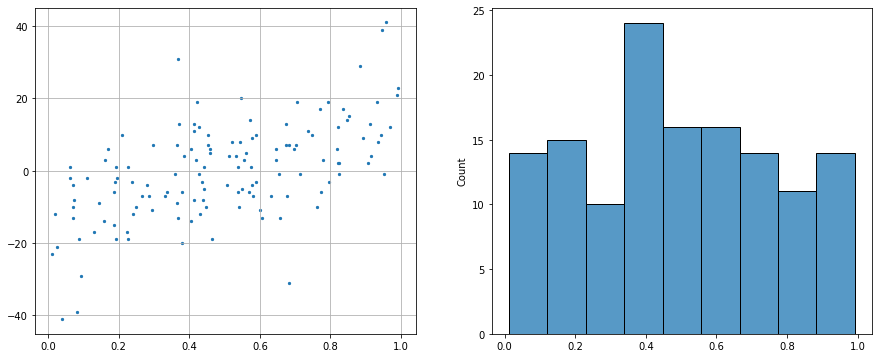

	 -> Scored 0.573

Validating on season 2016


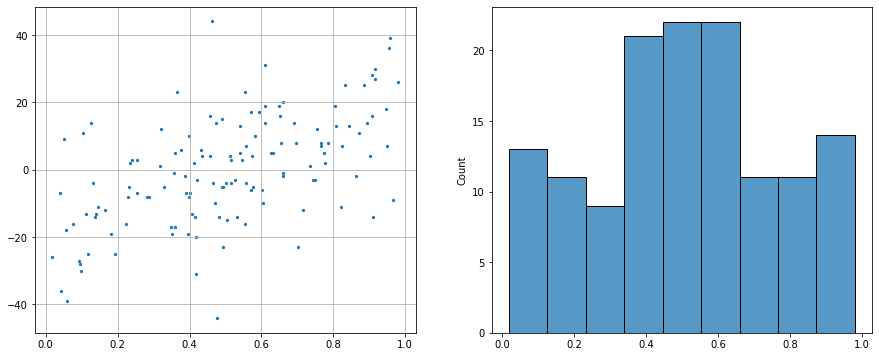

	 -> Scored 0.603

Validating on season 2017


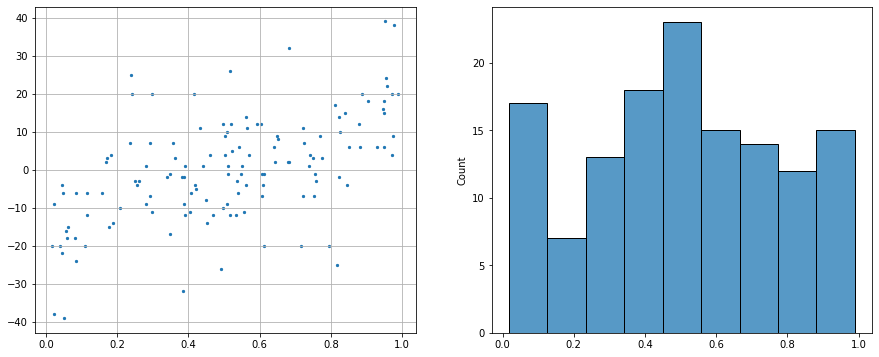

	 -> Scored 0.551

Validating on season 2018


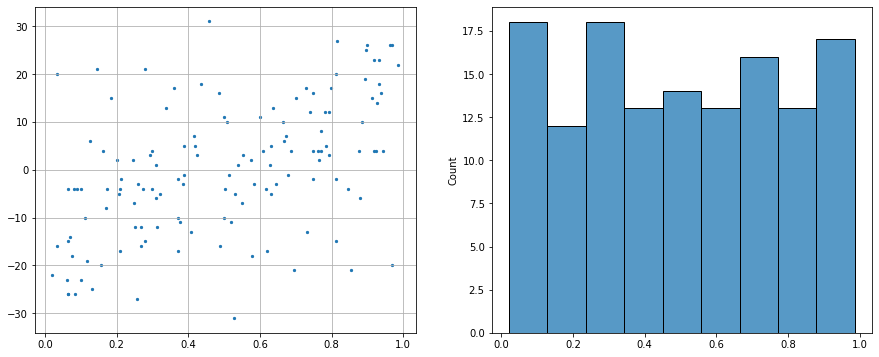

	 -> Scored 0.588

Validating on season 2019


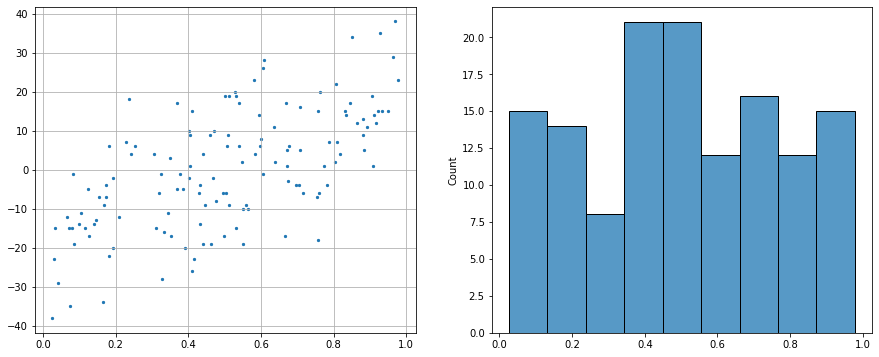

	 -> Scored 0.500

Validating on season 2021


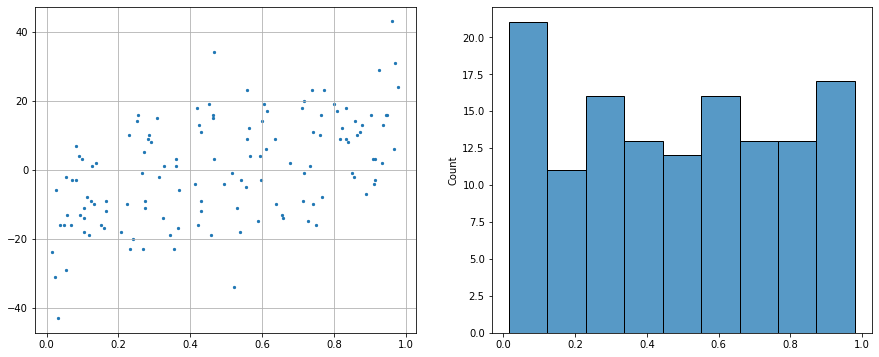

	 -> Scored 0.614

 Local CV is 0.572


In [ ]:
pred_tests = kfold_reg(df, df_test[features], plot=True, verbose=1, mode="cls")

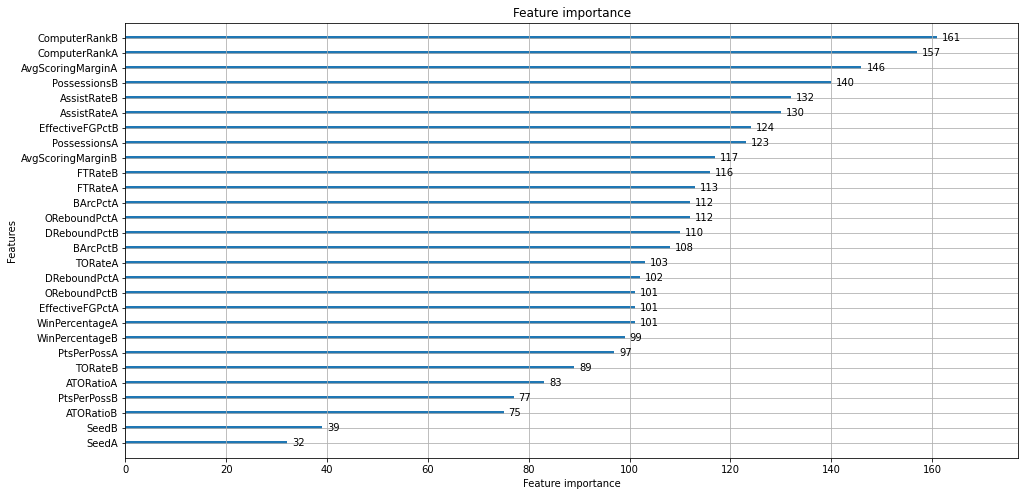

In [ ]:
import lightgbm
f, ax = plt.subplots(figsize=(16, 8))
model = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)
model.fit(X_train, y_train)
lightgbm.plot_importance(model, ax=ax)
plt.show()

In [ ]:
pred_tests

[array([0.723025  , 0.9723937 , 0.7159856 , ..., 0.566022  , 0.4110674 ,
        0.30998814], dtype=float32),
 array([0.6830976 , 0.9562635 , 0.77736366, ..., 0.49340212, 0.32766977,
        0.3429961 ], dtype=float32),
 array([0.5800932 , 0.95464915, 0.75556666, ..., 0.7106156 , 0.34155944,
        0.34374318], dtype=float32),
 array([0.6411276 , 0.9436818 , 0.74240726, ..., 0.66886556, 0.41748202,
        0.29618376], dtype=float32),
 array([0.62050647, 0.9507133 , 0.69323814, ..., 0.67431754, 0.4993279 ,
        0.26506427], dtype=float32),
 array([0.6089455 , 0.9303209 , 0.6796612 , ..., 0.64202374, 0.4398279 ,
        0.33477846], dtype=float32)]

### 6B.) Preparing for Automatic Submission

In [ ]:
pred_test = np.mean(pred_tests, 0)
sub = df_test[['ID', 'Pred']].copy()
sub['Pred'] = pred_test
# sub.to_csv('submission.csv', index=False)

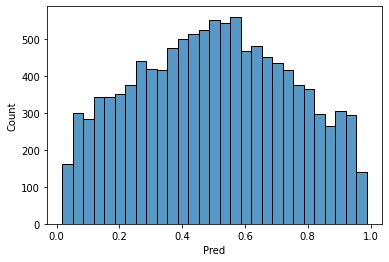

In [ ]:
_ = sns.histplot(sub['Pred'])

In [ ]:
x_train = X_train
x_val = X_validation 
y_val = y_validation

num_folds = 5

kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

# Create dataframes to store models calculated to apply ensemble method
# df_train_ens = pd.DataFrame()
# df_test_ens = pd.DataFrame()
# df_val_ens = pd.DataFrame()
# df_eva_ens = pd.DataFrame()

In [ ]:
import time
import numpy as np 
import numpy.ma as ma
import pandas as pd 
import datetime
import pickle
from tqdm import tqdm
import os
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from random import sample, seed

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingCVClassifier
from itertools import combinations
from hyperopt import fmin, space_eval, tpe, hp

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression,  RidgeClassifier, ElasticNet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from scipy import stats
from scipy.stats import skew

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse

from tune_sklearn import TuneSearchCV

from xgboost import XGBClassifier

from sklearn.metrics import log_loss

# Applying XG-Boost technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/XGboost_model.pkl','rb')
  xgb_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_XGboost.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( XGBClassifier(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(0,5)), 
              'n_estimators': hp.choice('n_estimators', range(0,10)), 
              'max_features': hp.choice('max_features', ['sqrt', 'auto']), 
              'warm_start': hp.choice('warm_start', [True])}

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  xgb_grid = make_pipeline( XGBClassifier(random_state = random_state, **best_params))

  # Train Model
  xgb_grid.fit(x_train,y_train)
  
  #Save model
  with open(models_path + '/XGboost_model.pkl', 'wb') as pickfile:
     pickle.dump(xgb_grid, pickfile)
  with open(models_path + '/best_params_XGboost.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

predicted_prob_val = xgb_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = xgb_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = xgb_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = xgb_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = xgb_grid.predict(x_val)

# Predict values of regression with test
# ypred_test = xgb_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(xgb_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Best parameters found: 
{'max_depth': 4, 'max_features': 'auto', 'n_estimators': 9, 'warm_start': True}
Evaluating results of the classification:
Log Loss for train, validation: 0.5426520392421849, 0.6135134979415295
Accuracy Score for train, validation: 0.7674144037780402, 0.5970149253731343
Precision Score for train, validation: 0.7674144037780402, 0.5970149253731343
Recall Score for train, validation: 0.7674144037780402, 0.5970149253731343
F1 Score for train, validation: 0.7674144037780402, 0.5970149253731343
AUROC for train, validation: 0.8565748408508953, 0.7153040766317665
GINI for train, validation: 0.7131496817017906, 0.4306081532635331
Feature importance:
Ejecución: 0.10413599014282227 seconds


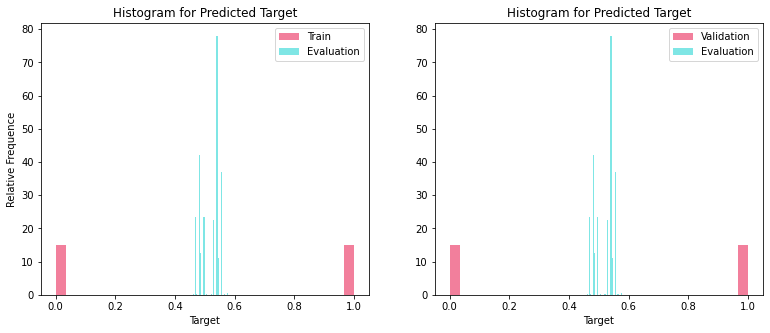

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test = xgb_grid.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_XGBOOST_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'xgb'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Random Forest technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/RandomForest_model.pkl','rb')
  rf_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_RandomForest.pkl','rb')
  best_params = pickle.load(infile)  
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( RandomForestClassifier(random_state = random_state, **params))
      
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'n_estimators': hp.choice('n_estimators', [100])
        , 'max_depth': hp.choice('max_depth', range(3,20,2))
        # , 'min_samples_split' : hp.choice('min_samples_split', range(1,10,1)) 
        # , 'max_features' : hp.choice('max_features', range(1,10,1)) 
        , 'bootstrap' : hp.choice('bootstrap', [True, False]) 
        
        # , 'min_samples_leaf' : hp.choice('min_samples_leaf', range(1,20,1))
    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  rf_grid = make_pipeline( RandomForestClassifier(random_state = random_state, **best_params))

  # Fit the model
  rf_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/RandomForest_model.pkl', 'wb') as pickfile:
     pickle.dump(rf_grid, pickfile)
  with open(models_path + '/best_params_RandomForest.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

predicted_prob_val = rf_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = rf_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = rf_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = rf_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = rf_grid.predict(x_val)

# Predict values of regression with test
# ypred_test = rf_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(rf_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Best parameters found: 
{'bootstrap': False, 'max_depth': 5, 'n_estimators': 100}
Evaluating results of the classification:
Log Loss for train, validation: 0.4659796217865475, 0.5868183670345685
Accuracy Score for train, validation: 0.7992916174734357, 0.6716417910447762
Precision Score for train, validation: 0.7992916174734357, 0.6619718309859155
Recall Score for train, validation: 0.7992916174734357, 0.7014925373134329
F1 Score for train, validation: 0.7992916174734357, 0.6811594202898551
AUROC for train, validation: 0.8849275657261061, 0.7433726887948318
GINI for train, validation: 0.7698551314522122, 0.4867453775896635
Feature importance:
Ejecución: 0.3139324188232422 seconds


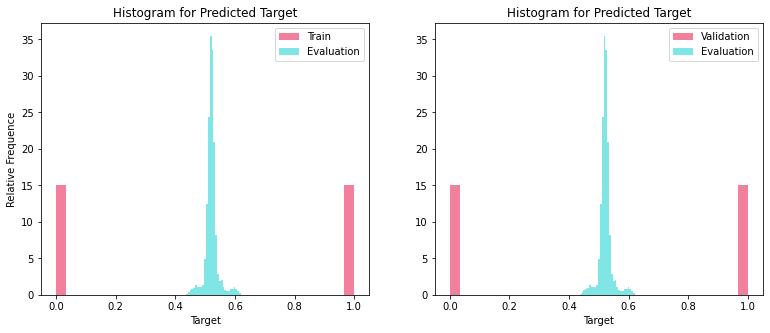

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test = rf_grid.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_RF_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'rf'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Light GBM technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/LGBM_model.pkl','rb')
  lgbm_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_LGBM.pkl','rb')
  best_params = pickle.load(infile)
else:
  #Define the grid to be searched in
  lgbm = LGBMClassifier(n_estimators=50, random_state = random_state)

  # Create the random grid
  parameters = {  'max_depth':[-1,1, 5, 10, 20, 30, 50]
                , 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2] 
                , 'num_leaves':[10, 20,40,60,80]                               
                , 'reg_alpha':[0,0.01,0.03,0.1,0.5,1]                
                # , 'min_child_samples':[5,10,15,30,50,100,300,500]

                }

  #Execute cross-validated grid search
  lgbm_grid = TuneSearchCV(lgbm, param_distributions=parameters, n_trials = 30, early_stopping = False, n_jobs = -1, random_state = random_state )

  # Train Model
  lgbm_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/LGBM_model.pkl', 'wb') as pickfile:
     pickle.dump(lgbm_grid, pickfile)
  with open(models_path + '/best_params_LGBM.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(lgbm_grid.best_params_)

print("======================================================================================")

predicted_prob_val = lgbm_grid.best_estimator_.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = lgbm_grid.best_estimator_.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = lgbm_grid.best_estimator_.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = lgbm_grid.best_estimator_.predict(x_train)

# Predict values of regression with validation
ypred_val = lgbm_grid.best_estimator_.predict(x_val)

# Predict values of regression with test
# ypred_test = lgbm_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(lgbm_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Best parameters found: 
{'max_depth': 1, 'learning_rate': 0.1, 'num_leaves': 10, 'reg_alpha': 1.0}
Evaluating results of the classification:
Log Loss for train, validation: 0.5404646027099562, 0.577300597537975
Accuracy Score for train, validation: 0.7225501770956316, 0.7014925373134329
Precision Score for train, validation: 0.718931475029036, 0.6956521739130435
Recall Score for train, validation: 0.730814639905549, 0.7164179104477612
F1 Score for train, validation: 0.7248243559718969, 0.7058823529411765
AUROC for train, validation: 0.8087499599252309, 0.773334818445088
GINI for train, validation: 0.6174999198504618, 0.546669636890176
Feature importance:
Ejecución: 0.05768609046936035 seconds


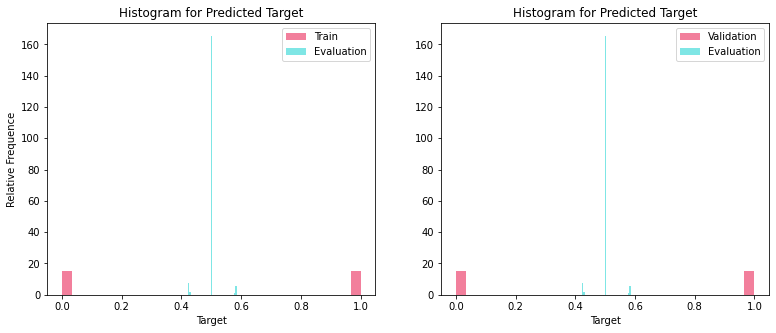

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  lgbm_grid.best_estimator_.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_LGBM_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'lgbm'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Lasso regression technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/Lasso_model.pkl','rb')
  lasso_grid = pickle.load(infile)

else:
  #Define the grid to be searched in
  # lasso = Lasso(random_state = random_state)
  lasso = LogisticRegression(random_state = random_state, penalty='l1', solver='liblinear')
  # Create the random grid
  parameters = {'C':[1/1e-6, 1/1e-5, 1/1e-4, 1/1e-3, 1/5e-2, 1/1e-2, 1/1e-1, 1/0.3, 1/0.5, 1/0.7, 1/1.0, 1/10.0, 1/50.0, 1/100.0]}

  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  lasso_grid = RandomizedSearchCV(estimator = lasso, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state, n_jobs = -1)
  # Fit the random search model
  lasso_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/Lasso_model.pkl', 'wb') as pickfile:
     pickle.dump(lasso_grid, pickfile)

print("======================================================================================")

predicted_prob_val = lasso_grid.best_estimator_.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = lasso_grid.best_estimator_.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = lasso_grid.best_estimator_.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = lasso_grid.best_estimator_.predict(x_train)

# Predict values of regression with validation
ypred_val = lasso_grid.best_estimator_.predict(x_val)

# Predict values of regression with test
# ypred_test = lasso_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(lasso.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Evaluating results of the classification:
Log Loss for train, validation: 0.5257964267722577, 0.5636878795106889
Accuracy Score for train, validation: 0.7107438016528925, 0.7164179104477612
Precision Score for train, validation: 0.7107438016528925, 0.7164179104477612
Recall Score for train, validation: 0.7107438016528925, 0.7164179104477612
F1 Score for train, validation: 0.7107438016528925, 0.7164179104477613
AUROC for train, validation: 0.8070013060889953, 0.7872577411450211
GINI for train, validation: 0.6140026121779907, 0.5745154822900422
Feature importance:
Ejecución: 0.0793910026550293 seconds


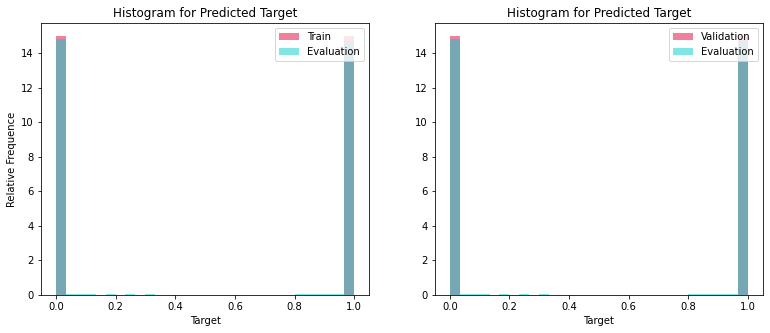

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  lasso_grid.best_estimator_.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_LASSO_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'lasso'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Ridge regression technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/Ridge_model.pkl','rb')
  ridge_grid = pickle.load(infile)

else:
  #Define the grid to be searched in
  # lasso = Lasso(random_state = random_state)
  Ridge = LogisticRegression(random_state = random_state, penalty='l2')
  # Create the random grid
  # parameters = {'C':[1/1e-6, 1/1e-5, 1/1e-4, 1/1e-3, 1/5e-2, 1/1e-2, 1/1e-1, 1/0.3, 1/0.5, 1/0.7, 1/1.0, 1/10.0, 1/50.0, 1/100.0]}
  # parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 0.3,0.7, 1.0, 10.0, 20.0, 30.0, 100.0]}
  parameters = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  ridge_grid = RandomizedSearchCV(estimator = Ridge, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state, n_jobs = -1)
  # Fit the random search model
  ridge_grid.fit(x_train, y_train)

  #Save model
  with open(models_path + '/Ridge_model.pkl', 'wb') as pickfile:
     pickle.dump(ridge_grid, pickfile)

print("======================================================================================")

predicted_prob_val = ridge_grid.best_estimator_.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = ridge_grid.best_estimator_.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = ridge_grid.best_estimator_.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = ridge_grid.best_estimator_.predict(x_train)

# Predict values of regression with validation
ypred_val = ridge_grid.best_estimator_.predict(x_val)

# Predict values of regression with test
# ypred_test = ridge_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(lasso.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Evaluating results of the classification:
Log Loss for train, validation: 0.5275570158463762, 0.5666873416333549
Accuracy Score for train, validation: 0.71900826446281, 0.7164179104477612
Precision Score for train, validation: 0.71900826446281, 0.7164179104477612
Recall Score for train, validation: 0.71900826446281, 0.7164179104477612
F1 Score for train, validation: 0.7190082644628101, 0.7164179104477613
AUROC for train, validation: 0.8065176210501959, 0.7832479394074404
GINI for train, validation: 0.6130352421003917, 0.5664958788148808
Feature importance:
Ejecución: 0.09042525291442871 seconds


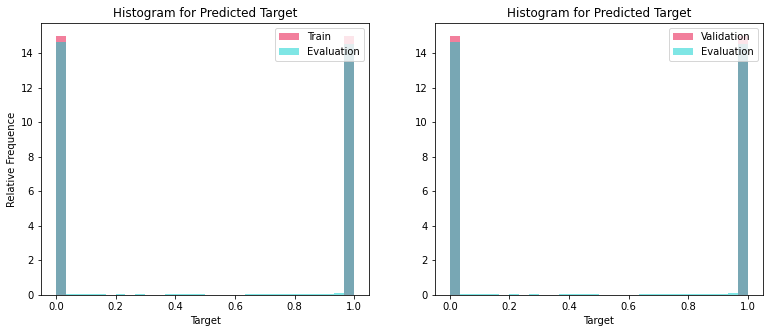

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  ridge_grid.best_estimator_.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_RIDGE_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'ridge'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Elastic net regression technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = 
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/elasticnet_model.pkl','rb')
  elasticnet_grid = pickle.load(infile)
else:
  #Define the model
  elasticnet = LogisticRegression(random_state = random_state, penalty='elasticnet', solver = 'saga')

  # Create the random grid
  parameters = {'C':[1/1e-6, 1/1e-5, 1/1e-4, 1/1e-3, 1/5e-2, 1/1e-2, 1/1e-1, 1/0.3, 1/0.5, 1/0.7, 1/1.0, 1/10.0, 1/50.0, 1/100.0]
                ,'l1_ratio': np.arange(0, 1, 0.01)}
  # Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  elasticnet_grid = RandomizedSearchCV(estimator = elasticnet, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state , n_jobs = -1)
  # Fit the random search model
  elasticnet_grid.fit(x_train, y_train)
  
  #Save model
  with open(models_path + '/elasticnet_model.pkl', 'wb') as pickfile:
     pickle.dump(elasticnet_grid, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(elasticnet_grid.best_params_)

print("======================================================================================")

predicted_prob_val = elasticnet_grid.best_estimator_.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = elasticnet_grid.best_estimator_.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = elasticnet_grid.best_estimator_.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = elasticnet_grid.best_estimator_.predict(x_train)

# Predict values of regression with validation
ypred_val = elasticnet_grid.best_estimator_.predict(x_val)

# Predict values of regression with test
# ypred_test = elasticnet_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(elasticnet_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Best parameters found: 
{'l1_ratio': 0.84, 'C': 10.0}
Evaluating results of the classification:
Log Loss for train, validation: 0.5236593793202233, 0.561273699707434
Accuracy Score for train, validation: 0.7142857142857143, 0.746268656716418
Precision Score for train, validation: 0.7142857142857143, 0.746268656716418
Recall Score for train, validation: 0.7142857142857143, 0.746268656716418
F1 Score for train, validation: 0.7142857142857143, 0.746268656716418
AUROC for train, validation: 0.8085833882764224, 0.790822009356204
GINI for train, validation: 0.6171667765528448, 0.5816440187124079
Feature importance:
Ejecución: 0.05525612831115723 seconds


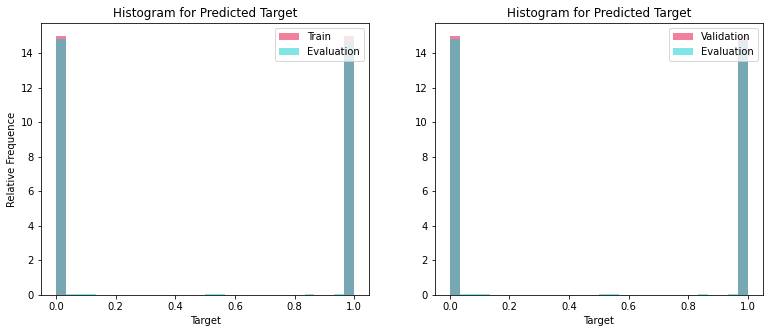

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  elasticnet_grid.best_estimator_.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_ENET_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'enet'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Support Vector Machine technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/SVM_model.pkl','rb')
  svm_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_SVM.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize  
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline(RobustScaler(), SVC(probability=True, cache_size=7000, **params))
     
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs=-1,error_score='raise').mean()

      return score

  # Define grid (space)
  parameters = {'C': hp.choice('C', [0.01, 0.1, 1, 10, 20, 100])
                , 'kernel': hp.choice('kernel',['poly', 'rbf', 'sigmoid'])
                , 'degree':hp.choice('degree',[2,3,4])
                # , 'gamma': hp.choice('gamma',[1, 0.1, 0.01, 0.001])
      }
  # Minimize function
  best = fmin(fn = param_selection_cv, 
            space = parameters, 
            algo = tpe.suggest, 
            max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)
  
  # Define model with best hyperparameters
  svm_grid = make_pipeline(RobustScaler(), SVC(probability=True, cache_size=7000, C=best_params['C']
                                               , kernel=best_params['kernel']
                                              #  , gamma=best_params['gamma']
                                                , degree=best_params['degree']
                                               ))
  # Train model
  svm_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/SVM_model.pkl', 'wb') as pickfile:
     pickle.dump(svm_grid, pickfile)
  with open(models_path + '/best_params_SVM.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

predicted_prob_val = svm_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = svm_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = svm_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = svm_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = svm_grid.predict(x_val)

# Predict values of regression with test
# ypred_test = svm_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(xgb_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Best parameters found: 
{'C': 1, 'degree': 3, 'kernel': 'rbf'}
Evaluating results of the classification:
Log Loss for train, validation: 0.47203596139533605, 0.5847075511331227
Accuracy Score for train, validation: 0.7874852420306966, 0.7014925373134329
Precision Score for train, validation: 0.7874852420306966, 0.7014925373134329
Recall Score for train, validation: 0.7874852420306966, 0.7014925373134329
F1 Score for train, validation: 0.7874852420306966, 0.7014925373134329
AUROC for train, validation: 0.8767230408316595, 0.7611940298507462
GINI for train, validation: 0.7534460816633191, 0.5223880597014925
Feature importance:
Ejecución: 1.0091397762298584 seconds


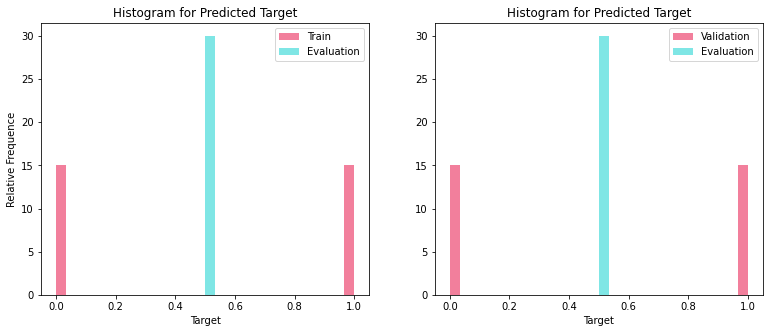

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  svm_grid.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_SVM_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'svm'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Gradient Boosting technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/GradientBoost_model.pkl','rb')
  gb_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_GradientBoost.pkl','rb')
  best_params = pickle.load(infile)
else:
    # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( GradientBoostingClassifier(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(3,20,1))
        , 'min_samples_split': hp.choice('min_samples_split', range(2,10,1))
        , 'n_estimators': hp.choice('n_estimators', [300])
        # , 'max_leaf_nodes': hp.choice('max_leaf_nodes', [2, 5, 10, 20, 50, 100])
        # , 'min_samples_leaf': hp.choice('min_samples_leaf', range(10,71,10))
        # , 'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01, 0.1, 0.2] )

    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  gb_grid = make_pipeline( GradientBoostingClassifier(random_state = random_state, **best_params))

  # Train Model
  gb_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/GradientBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(gb_grid, pickfile)
  with open(models_path + '/best_params_GradientBoost.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
     
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

predicted_prob_val = gb_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = gb_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = gb_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = gb_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = gb_grid.predict(x_val)

# Predict values of regression with test
# ypred_test = gb_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(gb_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Best parameters found: 
{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 300}
Evaluating results of the classification:
Log Loss for train, validation: 0.21286028572773938, 0.6738838430087477
Accuracy Score for train, validation: 0.9781582054309327, 0.6865671641791045
Precision Score for train, validation: 0.9753521126760564, 0.6865671641791045
Recall Score for train, validation: 0.9811097992916175, 0.6865671641791045
F1 Score for train, validation: 0.9782224838140083, 0.6865671641791045
AUROC for train, validation: 0.9978492045681056, 0.7262196480285142
GINI for train, validation: 0.9956984091362111, 0.4524392960570285
Feature importance:
Ejecución: 0.10069727897644043 seconds


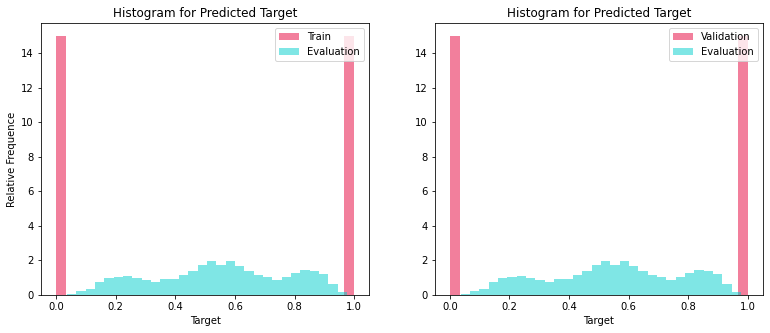

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  gb_grid.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_GB_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'gb'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Cat Boost technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/CatBoost_model.pkl','rb')
  cat_model_f = pickle.load(infile)
  infile = open(models_path + '/params_CatBoost_model.pkl','rb')
  best_params = pickle.load(infile)

else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      
      # Use params to create new model
      model = make_pipeline( CatBoostClassifier(random_state = random_state, **params))

      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  # parameters = {'iterations': hp.choice('iterations', [1000,6000])
  parameters = {'iterations': hp.choice('iterations', [250,100,500,1000, 2000])
        , 'eval_metric': hp.choice('eval_metric', ['Accuracy'])
        , 'early_stopping_rounds': hp.choice('early_stopping_rounds', [200])
        , 'learning_rate': hp.choice('learning_rate', [0.05, 0.005, 0.0005])
        , 'l2_leaf_reg': hp.choice('l2_leaf_reg', [1, 3, 5, 9])
        # , 'depth': hp.choice('depth', [4, 6, 10])
    }
# 
  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  cat_f = make_pipeline( CatBoostClassifier(random_state = random_state, **best_params))  

  # Train model  
  cat_model_f = cat_f.fit(x_train,y_train)

  #Save model
  with open(models_path + '/CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(cat_model_f, pickfile)
  with open(models_path + '/params_CatBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

predicted_prob_val = cat_model_f.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = cat_model_f.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = cat_model_f.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = cat_model_f.predict(x_train)

# Predict values of regression with validation
ypred_val = cat_model_f.predict(x_val)

# Predict values of regression with test
# ypred_test = cat_model_f.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(cat_model_f, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Best parameters found: 
{'early_stopping_rounds': 200, 'eval_metric': 'Accuracy', 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.005}
Evaluating results of the classification:
Log Loss for train, validation: 0.47252305184656884, 0.5776063950804103
Accuracy Score for train, validation: 0.7916174734356553, 0.7014925373134329
Precision Score for train, validation: 0.792654028436019, 0.7014925373134329
Recall Score for train, validation: 0.7898465171192444, 0.7014925373134329
F1 Score for train, validation: 0.7912477823772917, 0.7014925373134329
AUROC for train, validation: 0.8791414660256562, 0.7783470706170639
GINI for train, validation: 0.7582829320513125, 0.5566941412341277
Feature importance:
Ejecución: 0.0654592514038086 seconds


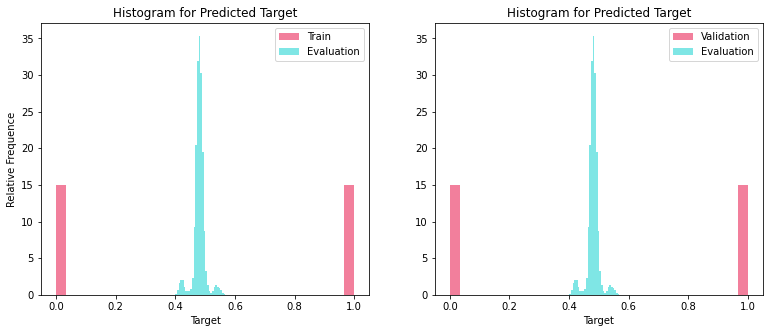

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  cat_model_f.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_CATBOOST_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'catboost'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Artificial Neural Network technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/ANN_model.pkl','rb')
  ann_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_ANN.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize  
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      # print(params)
      # Use params to create new model
      model = make_pipeline(RobustScaler(), MLPClassifier(random_state=random_state, max_iter=300, **params, early_stopping= True))
     
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs=-1,error_score='raise').mean()

      return score

  # Define grid (space)
  parameters = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (300,), (50,50,50), (100,100,100), (300,300,300), (50,100,50), (100,300,100), (300,100,300), (500,500,500,500)])
                #  'hidden_layer_sizes': 100 + hp.randint('hidden_layer_sizes', 40)
                # , 'alpha': hp.loguniform('alpha', -8*np.log(10), 3*np.log(10))
                , 'alpha': hp.choice('alpha', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]) 
                , 'activation':hp.choice('activation', ['relu', 'logistic', 'tanh'])
                , 'solver': hp.choice('solver', ['lbfgs', 'adam'])
                , 'learning_rate': hp.choice('learning_rate', ['invscaling', 'constant','adaptive'])
      }
 
  # Minimize function
  best = fmin(fn = param_selection_cv, 
            space = parameters, 
            algo = tpe.suggest, 
            max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)
  
  ann_grid = make_pipeline(RobustScaler(), MLPClassifier(random_state=random_state, max_iter=300, **best_params, early_stopping= True))

  # Train model
  ann_grid.fit(x_train,y_train)

  #Save model
  with open(models_path + '/ANN_model.pkl', 'wb') as pickfile:
     pickle.dump(ann_grid, pickfile)
  with open(models_path + '/best_params_ANN.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)

print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

predicted_prob_val = ann_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = ann_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = ann_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = ann_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = ann_grid.predict(x_val)

# Predict values of regression with test
# ypred_test = ann_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(ann_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Best parameters found: 
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (300, 300, 300), 'learning_rate': 'constant', 'solver': 'adam'}
Evaluating results of the classification:
Log Loss for train, validation: 0.4578585813040059, 0.5914089950395137
Accuracy Score for train, validation: 0.7857142857142857, 0.7238805970149254
Precision Score for train, validation: 0.7936893203883495, 0.7205882352941176
Recall Score for train, validation: 0.7721369539551358, 0.7313432835820896
F1 Score for train, validation: 0.7827648114901257, 0.7259259259259259
AUROC for train, validation: 0.8647033979222453, 0.7783470706170639
GINI for train, validation: 0.7294067958444905, 0.5566941412341277
Feature importance:
Ejecución: 0.4474649429321289 seconds


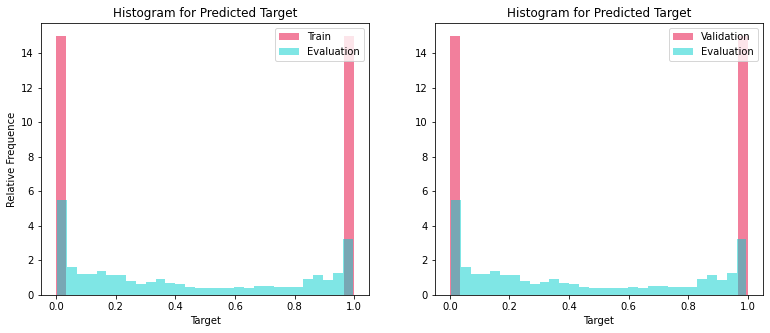

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  ann_grid.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_ANN_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'ann'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Applying Decision Tree technique

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = True

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model
  infile = open(models_path + '/DT_model.pkl','rb')
  dt_grid = pickle.load(infile)
  infile = open(models_path + '/best_params_DT.pkl','rb')
  best_params = pickle.load(infile)
else:
  # Define function to minimize
  def param_selection_cv(params, random_state=random_state, cv=kf, X=x_train, y=y_train):
      # Use params to create new model
      model = make_pipeline( DecisionTreeClassifier(random_state = random_state, **params))
      
      # Do cross validation with the same folds
      score = -cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs = -1,error_score = 'raise').mean()

      return score

  # Define grid (space)
  parameters = {'max_depth': hp.choice('max_depth', range(3,20,1))
        , 'min_samples_leaf': hp.choice('min_samples_leaf', [0.001, 0.01, 0.1, 0.2, 0.5, 1, 10, 50, 100, ])
        , 'max_features' : hp.choice('max_features', [0.2, 0.4,0.6, 0.8, "auto","log2","sqrt",None])
        , 'splitter':hp.choice('splitter', ["best","random"])
        , "max_leaf_nodes":hp.choice('max_leaf_nodes', [None,10,20,30,40,50,60,70,80,90])
        # , "min_weight_fraction_leaf":hp.choice('min_weight_fraction_leaf', [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5])
    }

  # Minimize function
  best = fmin(fn = param_selection_cv 
            , space = parameters 
            , algo = tpe.suggest 
            , max_evals = 30
            , rstate = np.random.RandomState(random_state)
          )
  
  # Retrieve best hyperparameters
  best_params = space_eval(parameters, best)

  # Define model with best hyperparameters
  dt_grid = make_pipeline( DecisionTreeClassifier(random_state = random_state, **best_params))

  # Train Model
  dt_grid.fit(x_train,y_train)
  
  #Save model
  with open(models_path + '/DT_model.pkl', 'wb') as pickfile:
     pickle.dump(dt_grid, pickfile)
  with open(models_path + '/best_params_DT.pkl', 'wb') as pickfile:
     pickle.dump(best_params, pickfile)
print("======================================================================================")
print("Best parameters found: ")
print(best_params)

print("======================================================================================")

predicted_prob_val = dt_grid.predict_proba(x_val)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = dt_grid.predict_proba(x_train)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = dt_grid.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = dt_grid.predict(x_train)

# Predict values of regression with validation
ypred_val = dt_grid.predict(x_val)

# Predict values of regression with test
# ypred_test = dt_grid.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(dt_grid, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)
Best parameters found: 
{'max_depth': 18, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 100, 'splitter': 'best'}
Evaluating results of the classification:
Log Loss for train, validation: 0.5448247157254182, 0.6129643789327145
Accuracy Score for train, validation: 0.7101534828807556, 0.6343283582089553
Precision Score for train, validation: 0.6969026548672567, 0.6097560975609756
Recall Score for train, validation: 0.743801652892562, 0.746268656716418
F1 Score for train, validation: 0.7195888063963449, 0.6711409395973154
AUROC for train, validation: 0.7868126828629137, 0.7120739585653821
GINI for train, validation: 0.5736253657258275, 0.4241479171307643
Feature importance:
Ejecución: 0.047751665115356445 seconds


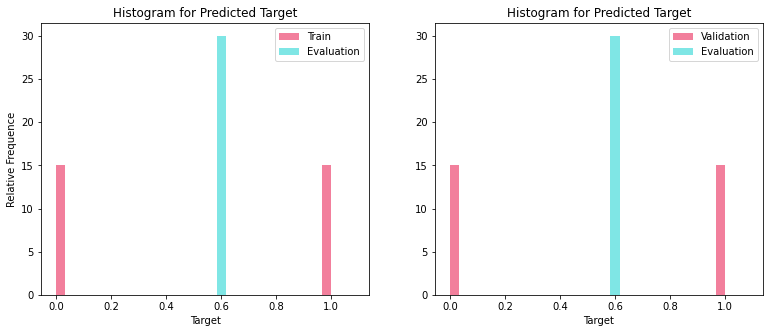

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  dt_grid.predict_proba(df_test[features])[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_DT_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'dt'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Stacking models

## With XGBoost as meta model

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = False

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model and weights
  infile = open(models_path + '/Stacked_meta_XGBoost_model.pkl','rb')
  stack_gen_model_xgb = pickle.load(infile)
  # infile = open(models_path + '/weights_meta_XGBoost_model.pkl','rb')
  # best_w = pickle.load(infile)
  # infile = open(models_path + '/rmse_meta_XGBoost_model.pkl','rb')
  # best_rmse_w = pickle.load(infile)

else:
  # Stacking - combine multiple regression models with a meta-regressor. 
  stack_gen = StackingCVClassifier(classifiers=(ridge_grid.best_estimator_
                                                , lasso_grid.best_estimator_
                                                # , svm_grid
                                                # ,  gb_grid
                                                # , xgb_grid
                                            # , lgbm_grid.best_estimator_
                                            # , rf_grid
                                            # , cat_model_f
                                            , elasticnet_grid.best_estimator_
                                            # , ann_grid
                                            # , dt_grid
                                            ),
                                meta_classifier=xgb_grid,
                                use_features_in_secondary=True
                                )
  # Train stacked model
  stack_gen_model_xgb = stack_gen.fit(x_train.values, y_train)
  # Calculate best weights for stacked prediction 
  # best_w, best_rmse_w = get_best_weights(x_val, number_models = 10, n_trials = 100)
  
  #Save model and weights
  with open(models_path + '/Stacked_meta_XGBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(stack_gen_model_xgb, pickfile)
  # with open(models_path + '/weights_meta_XGBoost_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_w, pickfile)
  # with open(models_path + '/rmse_meta_XGBoost_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_rmse_w, pickfile)

print("======================================================================================")
# print("The best weighs are:", best_w)
# print("The best rmse in validation was:", best_rmse_w)

print("======================================================================================")

predicted_prob_val = stack_gen_model_xgb.predict_proba(x_val.values)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = stack_gen_model_xgb.predict_proba(x_train.values)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = stack_gen_model_xgb.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = stack_gen_model_xgb.predict(x_train.values)

# Predict values of regression with validation
ypred_val = stack_gen_model_xgb.predict(x_val.values)

# Predict values of regression with test
# ypred_test = stack_gen_model_xgb.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(stack_gen_model_xgb, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Evaluating results of the classification:
Log Loss for train, validation: 0.5536972333928911, 0.580600417038398
Accuracy Score for train, validation: 0.7378984651711924, 0.7089552238805971
Precision Score for train, validation: 0.7378984651711924, 0.7
Recall Score for train, validation: 0.7378984651711924, 0.7313432835820896
F1 Score for train, validation: 0.7378984651711924, 0.7153284671532848
AUROC for train, validation: 0.8416774810463766, 0.7961684116729784
GINI for train, validation: 0.6833549620927533, 0.5923368233459567
Feature importance:
Ejecución: 1.1841812133789062 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


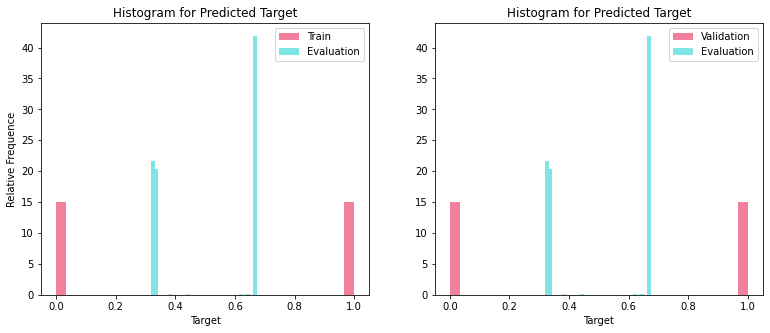

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  stack_gen_model_xgb.predict_proba(df_test[features].values)[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_ENSEMBLE_XGBoost_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'ens_xgb'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

## With Random Forest as meta model

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = False

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model and weights
  infile = open(models_path + '/Stacked_meta_RF_model.pkl','rb')
  stack_gen_model_rf = pickle.load(infile)
  # infile = open(models_path + '/weights_meta_RF_model.pkl','rb')
  # best_w = pickle.load(infile)
  # infile = open(models_path + '/rmse_meta_RF_model.pkl','rb')
  # best_rmse_w = pickle.load(infile)

else:
  # Stacking - combine multiple regression models with a meta-regressor. 
  stack_gen = StackingCVClassifier(classifiers=(ridge_grid.best_estimator_
                                                , lasso_grid.best_estimator_
                                                # , svm_grid
                                                # ,  gb_grid
                                                # , xgb_grid
                                            # , lgbm_grid.best_estimator_
                                            # , rf_grid
                                            # , cat_model_f
                                            , elasticnet_grid.best_estimator_
                                            # , ann_grid
                                            # , dt_grid
                                            ),
                                meta_classifier=ridge_grid.best_estimator_,
                                use_features_in_secondary=True
                                )
  # Train stacked model
  stack_gen_model_rf = stack_gen.fit(x_train.values, y_train)
  # Calculate best weights for stacked prediction 
  # best_w, best_rmse_w = get_best_weights(x_val, number_models = 10, n_trials = 100)
  
  #Save model and weights
  with open(models_path + '/Stacked_meta_RF_model.pkl', 'wb') as pickfile:
     pickle.dump(stack_gen_model_rf, pickfile)
  # with open(models_path + '/weights_meta_RF_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_w, pickfile)
  # with open(models_path + '/rmse_meta_RF_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_rmse_w, pickfile)

print("======================================================================================")

predicted_prob_val = stack_gen_model_rf.predict_proba(x_val.values)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = stack_gen_model_rf.predict_proba(x_train.values)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = stack_gen_model_rf.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = stack_gen_model_rf.predict(x_train.values)

# Predict values of regression with validation
ypred_val = stack_gen_model_rf.predict(x_val.values)

# Predict values of regression with test
# ypred_test = stack_gen_model_rf.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(stack_gen_model_rf, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Evaluating results of the classification:
Log Loss for train, validation: 0.5278771654447911, 0.5718505916955601
Accuracy Score for train, validation: 0.6989374262101535, 0.7238805970149254
Precision Score for train, validation: 0.6970760233918128, 0.7205882352941176
Recall Score for train, validation: 0.7036599763872491, 0.7313432835820896
F1 Score for train, validation: 0.700352526439483, 0.7259259259259259
AUROC for train, validation: 0.8019400369942389, 0.7819113388282469
GINI for train, validation: 0.6038800739884778, 0.5638226776564939
Feature importance:
Ejecución: 0.9051332473754883 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


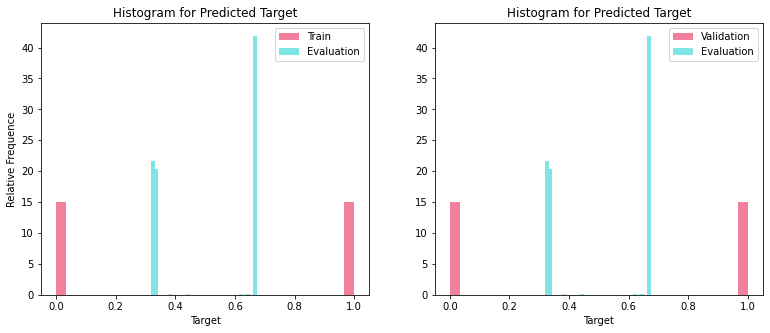

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  stack_gen_model_xgb.predict_proba(df_test[features].values)[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_ENSEMBLE_RF_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'ens_rf'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# With Light GBM as meta model

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = False

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model and weights
  infile = open(models_path + '/Stacked_meta_LGBM_model.pkl','rb')
  stack_gen_model_lgbm = pickle.load(infile)
  # infile = open(models_path + '/weights_meta_LGBM_model.pkl','rb')
  # best_w = pickle.load(infile)
  # infile = open(models_path + '/rmse_meta_LGBM_model.pkl','rb')
  # best_rmse_w = pickle.load(infile)

else:
  # Stacking - combine multiple regression models with a meta-regressor. 
  stack_gen = StackingCVClassifier(classifiers=(ridge_grid.best_estimator_
                                                , lasso_grid.best_estimator_
                                                # , svm_grid
                                                # ,  gb_grid
                                                # , xgb_grid
                                            # , lgbm_grid.best_estimator_
                                            # , rf_grid
                                            # , cat_model_f
                                            , elasticnet_grid.best_estimator_
                                            # , ann_grid
                                            # , dt_grid
                                            ),
                                meta_classifier=lgbm_grid.best_estimator_,
                                use_features_in_secondary=True
                                )
  # Train stacked model
  stack_gen_model_lgbm = stack_gen.fit(x_train.values, y_train)
  # Calculate best weights for stacked prediction 
  # best_w, best_rmse_w = get_best_weights(x_val, number_models = 10, n_trials = 100)
  
  #Save model and weights
  with open(models_path + '/Stacked_meta_LGBM_model.pkl', 'wb') as pickfile:
     pickle.dump(stack_gen_model_lgbm, pickfile)
  # with open(models_path + '/weights_meta_LGBM_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_w, pickfile)
  # with open(models_path + '/rmse_meta_LGBM_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_rmse_w, pickfile)

print("======================================================================================")

predicted_prob_val = stack_gen_model_lgbm.predict_proba(x_val.values)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = stack_gen_model_lgbm.predict_proba(x_train.values)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = stack_gen_model_lgbm.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = stack_gen_model_lgbm.predict(x_train.values)

# Predict values of regression with validation
ypred_val = stack_gen_model_lgbm.predict(x_val.values)

# Predict values of regression with test
# ypred_test = stack_gen_model_lgbm.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(stack_gen_model_lgbm, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Evaluating results of the classification:
Log Loss for train, validation: 0.5395719652269968, 0.5687264806440239
Accuracy Score for train, validation: 0.7243211334120425, 0.7014925373134329
Precision Score for train, validation: 0.7235294117647059, 0.7014925373134329
Recall Score for train, validation: 0.7260920897284534, 0.7014925373134329
F1 Score for train, validation: 0.7248084855627578, 0.7014925373134329
AUROC for train, validation: 0.8089973780646744, 0.7812430385386501
GINI for train, validation: 0.6179947561293488, 0.5624860770773001
Feature importance:
Ejecución: 1.1200475692749023 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


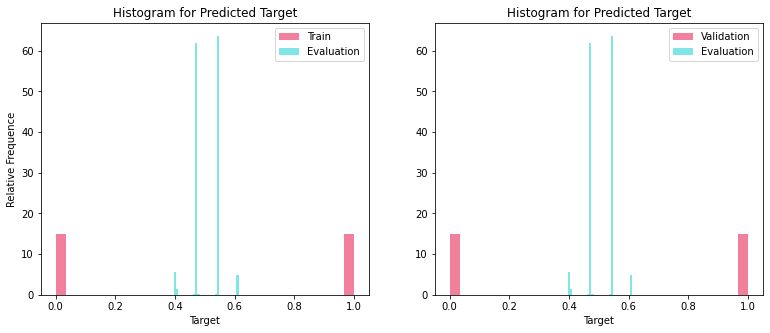

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  stack_gen_model_lgbm.predict_proba(df_test[features].values)[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_ENSEMBLE_LGBM_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'ens_rf'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

## With ANN as meta model

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = False

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model and weights
  infile = open(models_path + '/Stacked_meta_ANN_model.pkl','rb')
  stack_gen_model_ann = pickle.load(infile)
  # infile = open(models_path + '/weights_meta_ANN_model.pkl','rb')
  # best_w = pickle.load(infile)
  # infile = open(models_path + '/rmse_meta_ANN_model.pkl','rb')
  # best_rmse_w = pickle.load(infile)

else:
  # Stacking - combine multiple regression models with a meta-regressor. 
  stack_gen = StackingCVClassifier(classifiers=(ridge_grid.best_estimator_
                                                , lasso_grid.best_estimator_
                                                # , svm_grid
                                                # ,  gb_grid
                                                # , xgb_grid
                                            # , lgbm_grid.best_estimator_
                                            # , rf_grid
                                            # , cat_model_f
                                            , elasticnet_grid.best_estimator_
                                            # , ann_grid
                                            # , dt_grid
                                            ),
                                meta_classifier=ann_grid,
                                use_features_in_secondary=True
                                )
  # Train stacked model
  stack_gen_model_ann = stack_gen.fit(x_train.values, y_train)
  # Calculate best weights for stacked prediction 
  # best_w, best_rmse_w = get_best_weights(x_val, number_models = 10, n_trials = 100)
  
  #Save model and weights
  with open(models_path + '/Stacked_meta_ANN_model.pkl', 'wb') as pickfile:
     pickle.dump(stack_gen_model_ann, pickfile)
  # with open(models_path + '/weights_meta_ANN_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_w, pickfile)
  # with open(models_path + '/rmse_meta_ANN_model.pkl', 'wb') as pickfile:
  #    pickle.dump(best_rmse_w, pickfile)

print("======================================================================================")

predicted_prob_val = stack_gen_model_ann.predict_proba(x_val.values)[:, 1]
# false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_prob_val)

# optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]

predicted_prob_train = stack_gen_model_ann.predict_proba(x_train.values)[:, 1]
# # Predict values of regression with train
# ypred_train = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_train]

# # Predict values of regression with validation
# ypred_val = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_val]

# predicted_prob_test = stack_gen_model_ann.predict_proba(x_test)[:, 1]
# # Predict values of regression with test
# ypred_test = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_test]

# Predict values of regression with train
ypred_train = stack_gen_model_ann.predict(x_train.values)

# Predict values of regression with validation
ypred_val = stack_gen_model_ann.predict(x_val.values)

# Predict values of regression with test
# ypred_test = stack_gen_model_ann.predict(x_test)

print("Evaluating results of the classification:")
print("Log Loss for train, validation: {}, {}".format(log_loss(y_train, predicted_prob_train), log_loss(y_val, predicted_prob_val)))
print("Accuracy Score for train, validation: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_val, ypred_val)))
print("Precision Score for train, validation: {}, {}".format(precision_score(y_train, ypred_train), precision_score(y_val, ypred_val)))
print("Recall Score for train, validation: {}, {}".format(recall_score(y_train, ypred_train), recall_score(y_val, ypred_val)))
print("F1 Score for train, validation: {}, {}".format(f1_score(y_train, ypred_train), f1_score(y_val, ypred_val)))
print("AUROC for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train), roc_auc_score(y_val, predicted_prob_val)))
print("GINI for train, validation: {}, {}".format(roc_auc_score(y_train, predicted_prob_train) * 2 -1, roc_auc_score(y_val, predicted_prob_val) * 2 -1))

# Feature importance calculation
# imps = permutation_importance(stack_gen_model_ann, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)

print("Ejecución: %s seconds" % (time.time() - start_time))

X Train shape: (1694, 28)
Y Train shape: (1694,)
X Validation shape: (134, 28)
Y Validation shape: (134,)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Evaluating results of the classification:
Log Loss for train, validation: 0.5313359816709113, 0.57932285068032
Accuracy Score for train, validation: 0.704840613931523, 0.7164179104477612
Precision Score for train, validation: 0.693422519509476, 0.7543859649122807
Recall Score for train, validation: 0.7343565525383707, 0.6417910447761194
F1 Score for train, validation: 0.713302752293578, 0.6935483870967741
AUROC for train, validation: 0.8022146362813958, 0.7741145021162842
GINI for train, validation: 0.6044292725627916, 0.5482290042325684
Feature importance:
Ejecución: 9.117060661315918 seconds


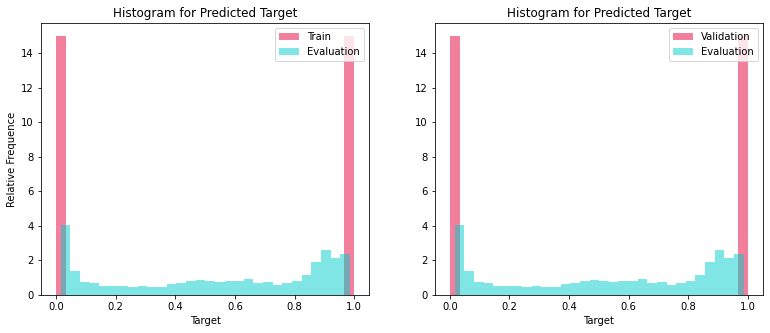

In [ ]:
#  Load test data
sub = df_test[['ID', 'Pred']].copy()

# Make prediction over evaluation data
# predicted_prob_eva = xgb_grid.predict_proba(X_sub)[:, 1]
# # Predict values of regression with validation
# df_evaluation.iloc[:,1] = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_prob_eva]
pred_test =  stack_gen_model_ann.predict_proba(df_test[features].values)[:, 1]
sub['Pred'] = pred_test

# Plotting results for fast comparisson
# plt.hist(y_test)
f, axs = plt.subplots(2,2,figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(y_train,alpha = 0.5, label='Train', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.ylabel('Relative Frequence')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
plt.subplot(1, 3, 2)
plt.hist(y_val,alpha = 0.5, label='Validation', density=True, bins = 30, color="#e6013b")
plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
plt.xlabel('Target')
plt.legend(loc='upper right')
plt.title(r'Histogram for Predicted Target')
# plt.subplot(1, 3, 3)
# plt.hist(y_test,alpha = 0.5, label='Test', density=True, bins = 30, color="#e6013b")
# plt.hist(sub.Pred,alpha = 0.5, label='Evaluation', density=True, bins = 30, color = "#00cfcc")
# plt.xlabel('Target')
# plt.legend(loc='upper right')
# plt.title(r'Histogram for Predicted Target')
# plt.show()

# Export file to submit in competition
sub.to_csv(submissions_path + '/March_ML_Mania_2022_Men_ENSEMBLE_ANN_Jimenez_v1.csv', index = False)

# Stack each model for ensemble method
# curr_mod = 'ens_rf'
# df_train_ens = pd.concat([df_train_ens, pd.Series(ypred_train)], axis=1)
# df_train_ens.columns = [*df_train_ens.columns[:-1], curr_mod]
# # df_test_ens = pd.concat([df_test_ens,  pd.Series(ypred_test)], axis=1)
# # df_test_ens.columns = [*df_test_ens.columns[:-1], curr_mod]
# df_val_ens = pd.concat([df_val_ens,  pd.Series(ypred_val)], axis=1)
# df_val_ens.columns = [*df_val_ens.columns[:-1], curr_mod]
# df_eva_ens = pd.concat([df_eva_ens, sub.Pred], axis=1)
# df_eva_ens.columns = [*df_eva_ens.columns[:-1], curr_mod]

# Using own ensemble method

## With XGBoost as meta model

In [ ]:
# Define function to get the best weights for stacking
def get_best_weights(df_x, number_models = 10, n_trials = 50):
  """
  Get the best weights for the stacking process
  :param df_x: Features
  :param number_models: Number of models considered in the stacking process
  :param n_trials: Number of trials to check

  :return best_weights and best_rmse
  """
  np.random.seed(random_state)
  weights_distr = np.random.uniform(low=1, high=10, size = number_models)
  weights_distr[0] = np.mean(weights_distr) + 30
  weights_distr[1] = np.mean(weights_distr) + 5
  weights_distr[2] = np.mean(weights_distr) + 5
  weights_distr[3] = np.mean(weights_distr) + 5
  weights_distr[4] = np.mean(weights_distr) + 5
  np.random.seed(random_state) 
  weights = np.random.dirichlet(weights_distr, n_trials)
  best_rmse = 999

  for i in range(n_trials):

    pred = ((weights[i][0] * stack_gen_model_xgb.predict(np.array(df_x)))
          + (weights[i][1] * cat_model_f.predict(df_x))
          + (weights[i][2] * lgbm_grid.best_estimator_.predict(df_x)) 
          + (weights[i][3] * xgb_grid.predict(df_x))
          + (weights[i][4] * gb_grid.predict(df_x))
          + (weights[i][5] * elasticnet_grid.best_estimator_.predict(df_x)) 
          + (weights[i][6] * lasso_grid.best_estimator_.predict(df_x))
          + (weights[i][7] * ridge_grid.best_estimator_.predict(df_x))
          + (weights[i][8] * svm_grid.predict(df_x))
          + (weights[i][9] * rf_grid.predict(df_x))
          + (weights[i][10] * ann_grid.predict(df_x))
          # + (weights[i][10] * dt_grid.predict(df_x))
          
          )
    metric_val = log_loss(y_val, pred)

    if metric_val < best_metric:
      best_metric = metric_val
      best_weights = weights[i]
  
  return best_weights, best_metric

# Get final prediction using the models trained

def ensemble_models_predict(df_x, weights):
  """
  Get the prediction using the stacking process
  :param df_x: Features
  :param weights: Best weights for the stacking process obtained with "get_best_weights" function

  :return best_weights and best_rmse
  """
  pred = ((weights[0] * stack_gen_model_xgb.predict(np.array(df_x)))
      + (weights[1] * cat_model_f.predict(df_x))
      + (weights[2] * lgbm_grid.best_estimator_.predict(df_x)) 
      + (weights[3] * xgb_grid.predict(df_x))
      + (weights[4] * gb_grid.predict(df_x))
      + (weights[5] * elasticnet_grid.best_estimator_.predict(df_x)) 
      + (weights[6] * lasso_grid.best_estimator_.predict(df_x))
      + (weights[7] * ridge_grid.best_estimator_.predict(df_x))
      + (weights[8] * svm_grid.predict(df_x))
      + (weights[9] * rf_grid.predict(df_x))
      + (weights[10] * ann_grid.predict(df_x))
      # + (weights[10] * dt_grid.predict(df_x))

      )
  return pred

In [ ]:
# Set flag to train or load model 
# To load the model then: load_model = True
# To train the model then: load_model = False
load_model = False

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Validation shape:",x_val.shape)
print("Y Validation shape:",y_val.shape)
# print("X Test shape:",x_test.shape)
# print("Y Test shape:",y_test.shape)

start_time = time.time()
#Print the optimal hyperparameters
if load_model:
  # Load model and weights
  infile = open(models_path + '/weights_meta_XGBoost_model.pkl','rb')
  best_w = pickle.load(infile)
  infile = open(models_path + '/rmse_meta_XGBoost_model.pkl','rb')
  best_metric_w = pickle.load(infile)

else:
  # Calculate best weights for stacked prediction 
  best_w, best_metric_w = get_best_weights(x_val, number_models = 11, n_trials = 100)
  
  #Save model and weights
  with open(models_path + '/weights_meta_XGBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(best_w, pickfile)
  with open(models_path + '/rmse_meta_XGBoost_model.pkl', 'wb') as pickfile:
     pickle.dump(best_metric_w, pickfile)

print("======================================================================================")
print("The best weighs are:", best_w)
print("The best rmse in validation was:", best_metric_w)

print("======================================================================================")
# Predict values of regression with train
ypred_train = ensemble_models_predict(x_train, best_w)
# Predict values of regression with validation
ypred_val = ensemble_models_predict(x_val, best_w)
# Predict values of regression with test
ypred_test = ensemble_models_predict(x_test, best_w)

print("RMSE Score for train, validation, test: {:.5f}, {:.5f}, {:.5f}".format(rmse(y_train, ypred_train), rmse(y_val, ypred_val), rmse(y_test, ypred_test)))

# Feature importance calculation
# imps = permutation_importance(stack_gen_model, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
# importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
# importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
# print(importance)


print("Ejecución: %s seconds" % (time.time() - start_time))